# Customer Focus

In this notebook, we will conduct both an RFM (Recency, Frequency, Monetary) analysis and a churn analysis to gain insights into our customer base and behavior. Through RFM analysis, we will segment customers based on their purchasing habits to identify high-value clients, engage with at-risk customers, and optimize our marketing strategies.

Additionally, the churn analysis will allow us to explore the key drivers of customer attrition, helping us address the factors that contribute to churn and develop strategies to improve customer retention.

By the end of this analysis, we aim to answer two critical questions:
- What is the composition of our customer base, and how can we segment it to better understand customer behavior?
- What are the key factors driving customer churn, and how can we address them to improve retention?

## Libraries

In [1]:
# Ignore warnings
import warnings
warnings.filterwarnings('ignore')

# Import necessary libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm

# Import libraries for preprocessing and machine learning
from sklearn.preprocessing import MinMaxScaler, OrdinalEncoder
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline

# Import machine learning models
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier

# Import metrics for model evaluation
from sklearn.metrics import (
    classification_report, confusion_matrix, 
    recall_score, precision_score, accuracy_score, f1_score
)

# Import library for data visualization
import squarify

from modules.constants import *


## RFM

In this section, we perform an RFM (Recency, Frequency, Monetary) analysis to segment customers based on their purchasing behavior. This helps identify high-value customers and those at risk of churn, enabling targeted marketing strategies to improve retention and revenue.

### Data Loading

In [2]:
customer_reviews = pd.read_csv(TBL_CUSTOMER_REVIEWS_PATH)


In [3]:
orders = pd.read_csv(TBL_ORDERS_PATH)

# Visualizziamo le prime righe del dataset
orders.head()


,order_id,customer_id,store_id,product_id,direction,gross_price,price_reduction,purchase_datetime
0,8fe4346b53d0c781b275a614175804de,23,49,35551922,1,125.40,0.0,2022-10-04T182851
1,8fe4346b53d0c781b275a614175804de,23,49,30344384,1,8.30,0.0,2022-10-04T182851
2,8fe4346b53d0c781b275a614175804de,23,49,33794292,1,1.99,0.0,2022-10-04T182851
3,8fe4346b53d0c781b275a614175804de,23,49,33795776,1,5.10,0.0,2022-10-04T182851
4,8fe4346b53d0c781b275a614175804de,23,49,36235381,1,76.05,0.0,2022-10-04T182851


### Data Preprocessing

In this step, we are preparing the data by filtering and converting date formats to ensure accurate and relevant analysis. 

In [4]:
orders = orders[orders['direction'] == 1]

# Convert date columns to datetime format
orders['purchase_datetime'] = pd.to_datetime(orders['purchase_datetime'])
reference_date = pd.to_datetime('2023-05-01')

# Filter data within the period of interest (from May 1, 2022 to April 30, 2023)
start_date = '2022-05-01'
end_date = '2023-04-30'
filtered_orders = orders[(orders['purchase_datetime'] >= start_date) & 
                         (orders['purchase_datetime'] <= end_date)]

Filtering the dataset to include only purchase transactions (direction = 1). Converting the purchase_datetime column to datetime format and setting a reference date. Further filtering the data to include transactions within the period of interest (from May 1, 2022, to April 30, 2023).

### Compute Repurchase time

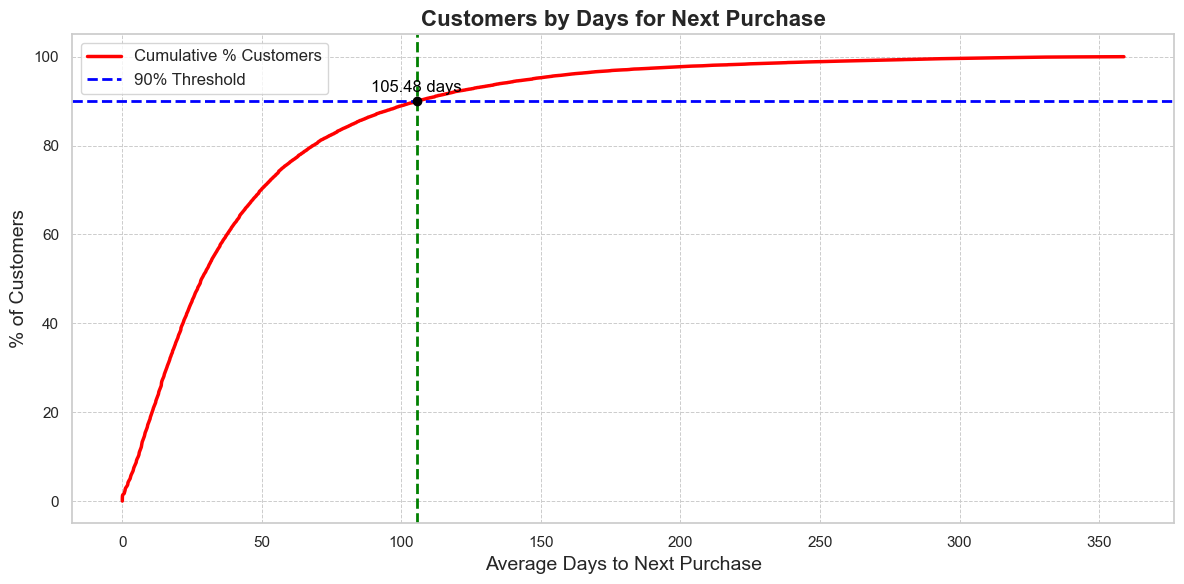

In [5]:


# Convert purchase_datetime to datetime format
filtered_orders['purchase_datetime'] = pd.to_datetime(filtered_orders['purchase_datetime'])

# Remove duplicate purchases per customer by order_id and purchase_datetime
unique_purchases = filtered_orders.drop_duplicates(subset=['customer_id', 'order_id', 'purchase_datetime'])

# Group by customer_id and count the number of unique purchases
purchase_counts = unique_purchases.groupby('customer_id').size().reset_index(name='purchase_count')

# Filter customers with at least two purchases
eligible_customers = purchase_counts[purchase_counts['purchase_count'] >= 2]['customer_id']

# Function to calculate repurchase intervals
def calculate_repurchase_intervals(dates):
    dates = dates.sort_values().unique()
    intervals = np.diff(dates) / np.timedelta64(1, 'D')
    return intervals

# Apply the function to calculate repurchase intervals for each customer
repurchase_intervals = unique_purchases[unique_purchases['customer_id'].isin(eligible_customers)].groupby('customer_id')['purchase_datetime'].apply(calculate_repurchase_intervals)

# Calculate the mean repurchase intervals for each customer
mean_repurchase_intervals = repurchase_intervals.apply(lambda x: np.mean(x) if len(x) > 0 else np.nan).dropna()

# Calculate the 90th percentile of the mean repurchase intervals
inactivity_threshold = np.percentile(mean_repurchase_intervals, 90)

# Calculate the cumulative percentage of customers by days between purchases
sorted_intervals = np.sort(mean_repurchase_intervals)
cum_percentage = np.arange(len(sorted_intervals)) / float(len(sorted_intervals)) * 100

# Find the point corresponding to 90% of customers
threshold_index = np.where(cum_percentage >= 90)[0][0]
threshold_days = sorted_intervals[threshold_index]

# Miglioramento del design per la visualizzazione
plt.figure(figsize=(12, 6))
sns.set(style="whitegrid")  # Design pulito e professionale

# Grafico a linee della percentuale cumulativa
plt.plot(sorted_intervals, cum_percentage, color='red', linewidth=2.5, label='Cumulative % Customers')

# Linee tratteggiate per il 90% threshold
plt.axhline(y=90, color='blue', linestyle='--', linewidth=2, label='90% Threshold')
plt.axvline(x=threshold_days, color='green', linestyle='--', linewidth=2)

# Punto di intersezione con etichetta
plt.scatter(threshold_days, 90, color='black', zorder=5)
plt.text(threshold_days, 92, f'{threshold_days:.2f} days', horizontalalignment='center', fontsize=12, color='black')

# Titoli e etichette migliorate
plt.title('Customers by Days for Next Purchase', fontsize=16, weight='bold')
plt.xlabel('Average Days to Next Purchase', fontsize=14)
plt.ylabel('% of Customers', fontsize=14)

# Legenda e impostazioni finali del grafico
plt.legend(fontsize=12)
plt.grid(True, which='both', linestyle='--', linewidth=0.7)
plt.tight_layout()  # Ottimizza il layout per presentazione

# Mostra il grafico
plt.show()



Among the customers, 70,170 have made at least two purchases. The 90th percentile of the average days between purchases is 105.48 days, which serves as the repurchase threshold. The cumulative percentage graph shows that 90% of customers make their next purchase within this timeframe. This threshold helps in identifying active and inactive customers based on their repurchase behavior.

### Segment inactive-active customers

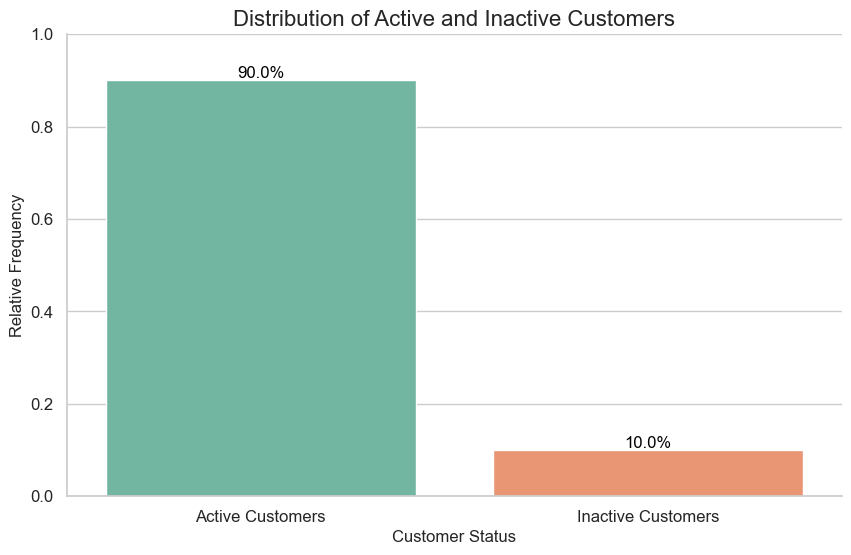

In [6]:
# Segment customers into active and inactive based on inactivity threshold
inactive_customers = filtered_orders[filtered_orders['customer_id'].isin(
    mean_repurchase_intervals[mean_repurchase_intervals > inactivity_threshold].index)]
active_customers = filtered_orders[filtered_orders['customer_id'].isin(
    mean_repurchase_intervals[mean_repurchase_intervals <= inactivity_threshold].index)]

# Count the number of active and inactive customers
active_count = active_customers['customer_id'].nunique()
inactive_count = inactive_customers['customer_id'].nunique()



# Calcolo della frequenza relativa
total_customers = active_count + inactive_count
active_relative_freq = active_count / total_customers
inactive_relative_freq = inactive_count / total_customers

# Creare un DataFrame per visualizzare più facilmente i dati
data = pd.DataFrame({
    'Customer Status': ['Active Customers', 'Inactive Customers'],
    'Relative Frequency': [active_relative_freq, inactive_relative_freq]
})

# Impostazioni di visualizzazione
plt.figure(figsize=(10, 6))
sns.set(style="whitegrid")  # Imposta uno stile pulito e professionale

# Creazione del bar plot
ax = sns.barplot(
    x='Customer Status',
    y='Relative Frequency',
    data=data,
    palette='Set2'
)

# Annotazioni: mostrare le percentuali sopra ogni barra
for p in ax.patches:
    ax.annotate(f'{p.get_height():.1%}', 
                (p.get_x() + p.get_width() / 2., p.get_height()), 
                ha='center', va='center', fontsize=12, color='black', 
                xytext=(0, 5), textcoords='offset points')

# Miglioramento della leggibilità e dell'estetica del grafico
plt.title('Distribution of Active and Inactive Customers', fontsize=16)
plt.xlabel('Customer Status', fontsize=12)
plt.ylabel('Relative Frequency', fontsize=12)
plt.ylim(0, 1)  # Assicura che l'asse Y mostri valori da 0 a 1
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
sns.despine()  # Rimuove le spine laterali per un look più pulito

# Mostra il grafico
plt.show()



The bar chart shows the distribution of active and inactive customers based on the repurchase threshold. Out of the total, 63,153 customers are classified as active, while 7,017 are considered inactive. This segmentation helps in identifying customers who are likely to continue purchasing and those who might need re-engagement strategies.

### RFM for active customers

In [7]:
# Calculate RFM metrics for active customers
rfm_active = active_customers.groupby('customer_id').agg({
    'purchase_datetime': lambda x: (reference_date - x.max()).days,
    'order_id': 'nunique',
    'gross_price': 'sum'
}).reset_index()

# Rename the columns
rfm_active.columns = ['customer_id', 'recency', 'frequency', 'monetary']

# Display the first few rows of the RFM DataFrame for active customers
rfm_active.head()


,customer_id,recency,frequency,monetary
0,23,69,7,490.60
1,30,281,2,10179.56
2,32,28,3,58.85
3,48,23,14,1577.33
4,50,70,2,28.75



We calculate the RFM (Recency, Frequency, Monetary) metrics for active customers by grouping the data by customer ID. Recency is calculated as the number of days since the last purchase, frequency as the number of unique orders, and monetary as the total amount spent. The columns are then renamed for clarity, and the first few rows of the RFM DataFrame are displayed, showing key metrics for evaluating customer value.


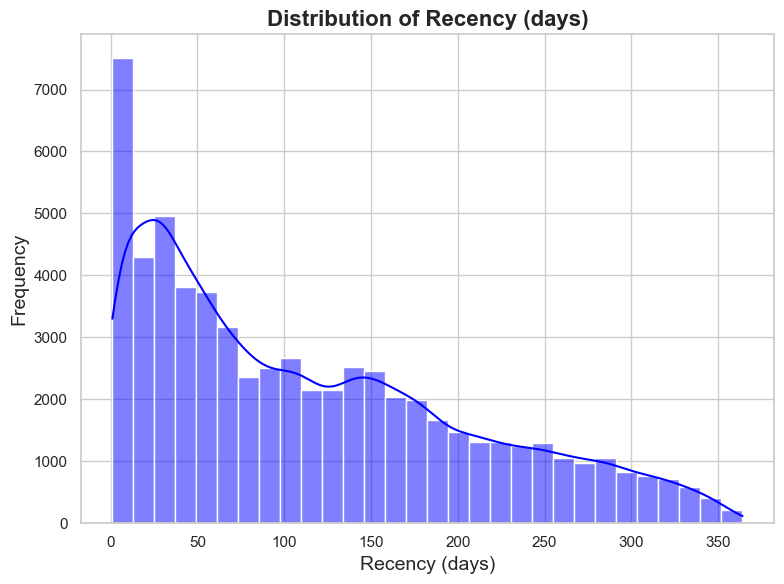

In [8]:


# Impostazioni di visualizzazione
plt.figure(figsize=(8, 6))
sns.set(style="whitegrid")  # Design pulito e professionale

# Grafico della distribuzione di Recency
sns.histplot(rfm_active['recency'], bins=30, kde=True, color='blue')

# Miglioramento del titolo e delle etichette
plt.title('Distribution of Recency (days)', fontsize=16, weight='bold')
plt.xlabel('Recency (days)', fontsize=14)
plt.ylabel('Frequency', fontsize=14)

# Mostra il grafico
plt.tight_layout()
plt.show()


In [9]:
rfm_active['recency'].describe()

count    63153.000000
mean       115.053046
std         92.332625
min          1.000000
25%         35.000000
50%         93.000000
75%        177.000000
max        364.000000
Name: recency, dtype: float64

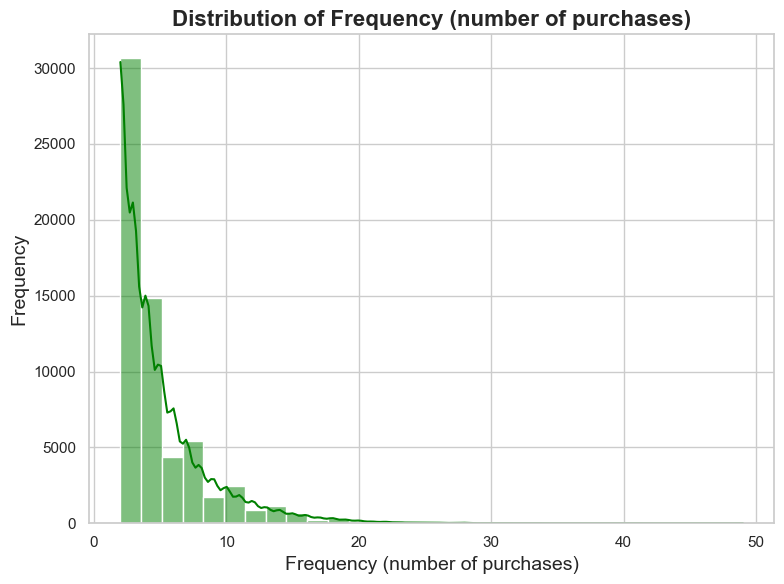

In [10]:
# Impostazioni di visualizzazione
plt.figure(figsize=(8, 6))
sns.set(style="whitegrid")

# Grafico della distribuzione di Frequency
sns.histplot(rfm_active['frequency'], bins=30, kde=True, color='green')

# Miglioramento del titolo e delle etichette
plt.title('Distribution of Frequency (number of purchases)', fontsize=16, weight='bold')
plt.xlabel('Frequency (number of purchases)', fontsize=14)
plt.ylabel('Frequency', fontsize=14)

# Mostra il grafico
plt.tight_layout()
plt.show()


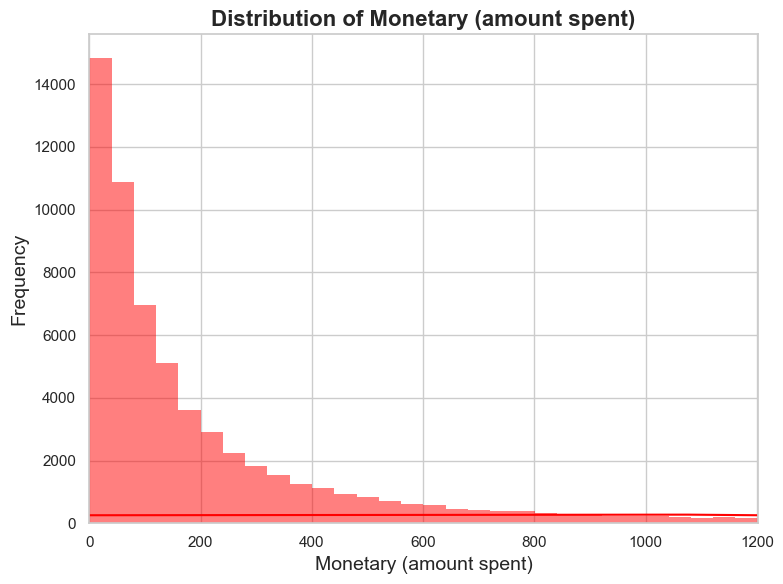

In [11]:


# Calcolo del 95° percentile per il limite di x
percentile_95 = rfm_active['monetary'].quantile(0.95)
max_value = rfm_active['monetary'].max()

# Impostazioni di visualizzazione
plt.figure(figsize=(8, 6))
sns.set(style="whitegrid")  # Design pulito e professionale

# Grafico della distribuzione di Monetary limitato al 95° percentile
sns.histplot(rfm_active['monetary'], bins=30, kde=True, color='red', binrange=(0, percentile_95))

# Miglioramento del titolo e delle etichette
plt.title('Distribution of Monetary (amount spent)', fontsize=16, weight='bold')
plt.xlabel('Monetary (amount spent)', fontsize=14)
plt.ylabel('Frequency', fontsize=14)

# Limitazione dell'asse x al 95° percentile
plt.xlim(0, percentile_95)



# Mostra il grafico
plt.tight_layout()
plt.show()



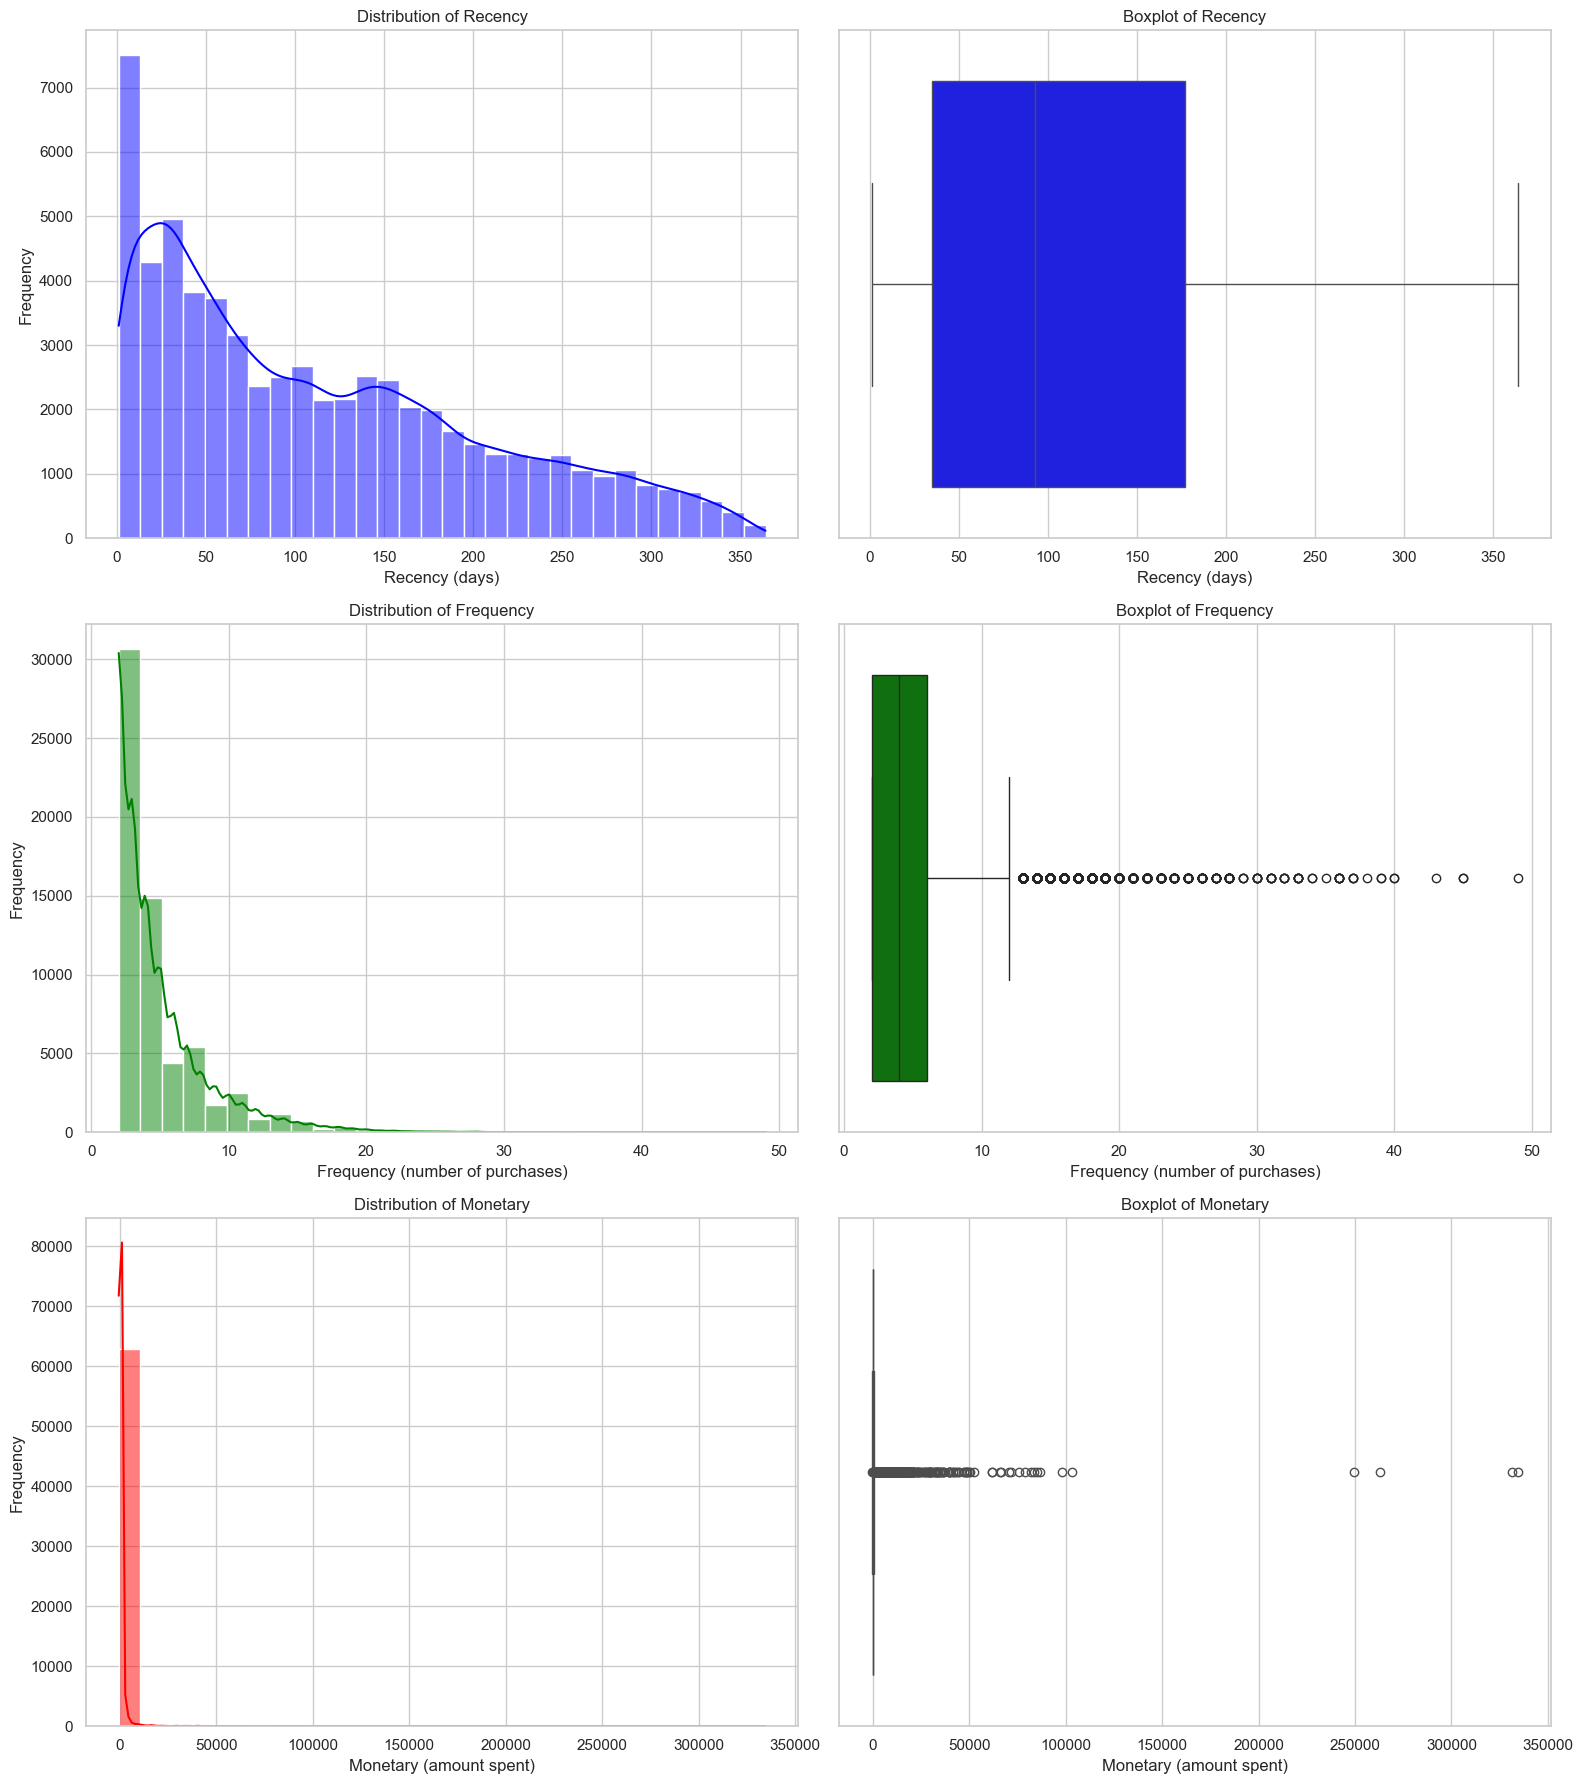

In [12]:
# Plot the distribution of Recency, Frequency, and Monetary with histograms and boxplots

fig, axes = plt.subplots(3, 2, figsize=(16, 18))

# Recency
sns.histplot(rfm_active['recency'], bins=30, kde=True, color='blue', ax=axes[0, 0])
axes[0, 0].set_title('Distribution of Recency')
axes[0, 0].set_xlabel('Recency (days)')
axes[0, 0].set_ylabel('Frequency')

sns.boxplot(x=rfm_active['recency'], color='blue', ax=axes[0, 1])
axes[0, 1].set_title('Boxplot of Recency')
axes[0, 1].set_xlabel('Recency (days)')

# Frequency
sns.histplot(rfm_active['frequency'], bins=30, kde=True, color='green', ax=axes[1, 0])
axes[1, 0].set_title('Distribution of Frequency')
axes[1, 0].set_xlabel('Frequency (number of purchases)')
axes[1, 0].set_ylabel('Frequency')

sns.boxplot(x=rfm_active['frequency'], color='green', ax=axes[1, 1])
axes[1, 1].set_title('Boxplot of Frequency')
axes[1, 1].set_xlabel('Frequency (number of purchases)')

# Monetary
sns.histplot(rfm_active['monetary'], bins=30, kde=True, color='red', ax=axes[2, 0])
axes[2, 0].set_title('Distribution of Monetary')
axes[2, 0].set_xlabel('Monetary (amount spent)')
axes[2, 0].set_ylabel('Frequency')

sns.boxplot(x=rfm_active['monetary'], color='red', ax=axes[2, 1])
axes[2, 1].set_title('Boxplot of Monetary')
axes[2, 1].set_xlabel('Monetary (amount spent)')

plt.tight_layout()
plt.show()

The visualizations show the distribution and boxplots of the RFM metrics for active customers:

- Recency: Most customers made their last purchase within the last 100 days, with a right-skewed distribution. The boxplot indicates a wide range of recency values, with no extreme outliers.
- Frequency: The majority of customers have made between 1 and 10 purchases, with a steep decline in the number of customers making more frequent purchases. The boxplot reveals several outliers, indicating some customers have made significantly more purchases.
- Monetary: The distribution is highly skewed to the right, with most customers spending less than 200. The boxplot shows a large number of outliers, indicating that a few customers have made very high-value purchases.

### Divide each metric in groups 

In [13]:
# Calcola le classi per ciascuna metrica utilizzando i terzili
rfm_active['recency_score'] = pd.qcut(rfm_active['recency'], q=3, labels=['High', 'Medium', 'Low'])
rfm_active['frequency_score'] = pd.qcut(rfm_active['frequency'], q=3, labels=['Low', 'Medium', 'High'])
rfm_active['monetary_score'] = pd.qcut(rfm_active['monetary'], q=3, labels=['Low', 'Medium', 'High'])

# Visualizza le prime righe del DataFrame RFM aggiornato
print(rfm_active.head())

# Ottieni i limiti dei terzili
recency_bins = pd.qcut(rfm_active['recency'], q=3, retbins=True)[1]
frequency_bins = pd.qcut(rfm_active['frequency'], q=3, retbins=True)[1]
monetary_bins = pd.qcut(rfm_active['monetary'], q=3, retbins=True)[1]

print("Recency Tertiles:")
print(recency_bins)

print("\nFrequency Tertiles:")
print(frequency_bins)

print("\nMonetary Tertiles:")
print(monetary_bins)

   customer_id  recency  frequency  monetary recency_score frequency_score  \
0           23       69          7    490.60        Medium            High   
1           30      281          2  10179.56           Low             Low   
2           32       28          3     58.85          High             Low   
3           48       23         14   1577.33          High            High   
4           50       70          2     28.75        Medium             Low   

  monetary_score  
0           High  
1           High  
2            Low  
3           High  
4            Low  
Recency Tertiles:
[  1.  51. 148. 364.]

Frequency Tertiles:
[ 2.  3.  5. 49.]

Monetary Tertiles:
[-6.09180000e+02  6.05500000e+01  2.08323333e+02  3.34650240e+05]


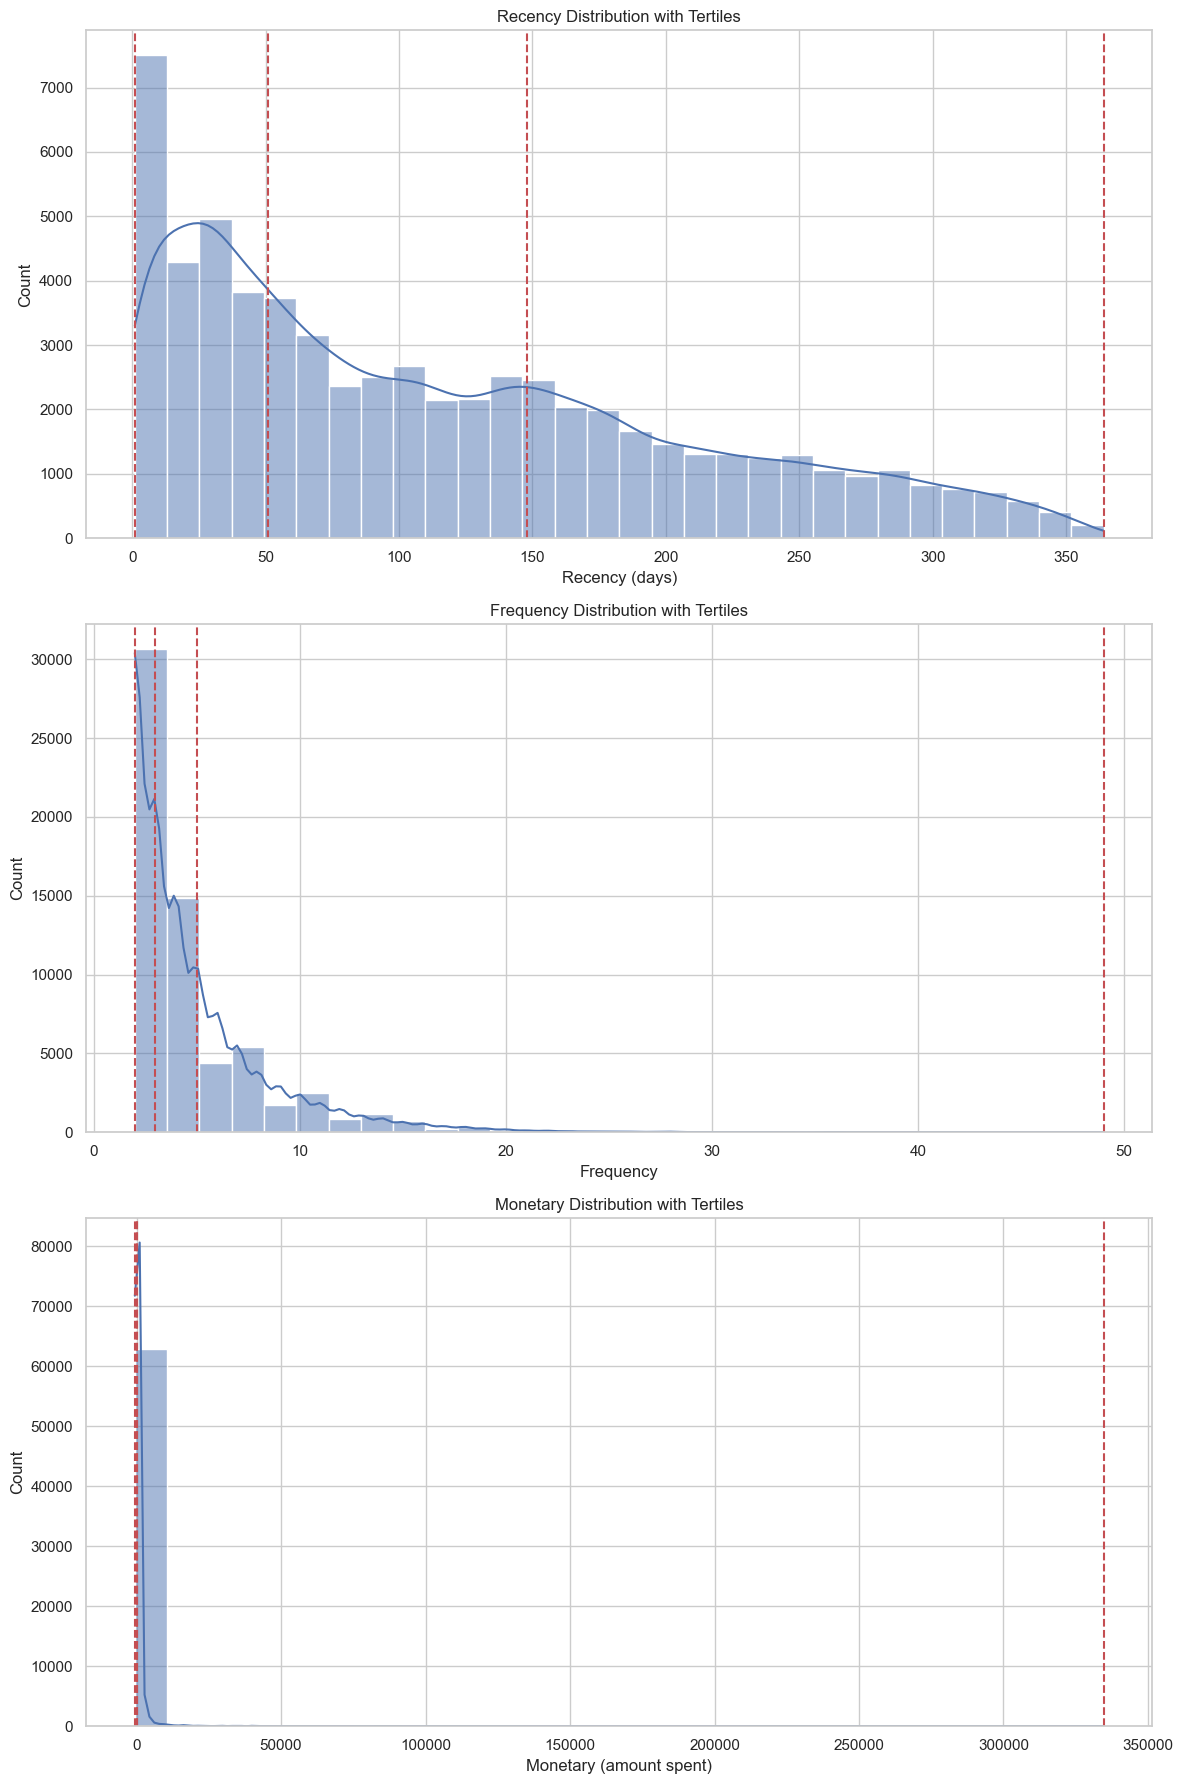

In [14]:
# Visualizza la distribuzione di recency, frequency e monetary con i limiti dei terzili
fig, axes = plt.subplots(3, 1, figsize=(12, 18))

# Recency distribution with tertiles
sns.histplot(rfm_active['recency'], bins=30, kde=True, ax=axes[0])
for bin in recency_bins:
    axes[0].axvline(bin, color='r', linestyle='--')
axes[0].set_title('Recency Distribution with Tertiles')
axes[0].set_xlabel('Recency (days)')
axes[0].set_ylabel('Count')

# Frequency distribution with tertiles
sns.histplot(rfm_active['frequency'], bins=30, kde=True, ax=axes[1])
for bin in frequency_bins:
    axes[1].axvline(bin, color='r', linestyle='--')
axes[1].set_title('Frequency Distribution with Tertiles')
axes[1].set_xlabel('Frequency')
axes[1].set_ylabel('Count')

# Monetary distribution with tertiles
sns.histplot(rfm_active['monetary'], bins=30, kde=True, ax=axes[2])
for bin in monetary_bins:
    axes[2].axvline(bin, color='r', linestyle='--')
axes[2].set_title('Monetary Distribution with Tertiles')
axes[2].set_xlabel('Monetary (amount spent)')
axes[2].set_ylabel('Count')

plt.tight_layout()
plt.show()

The histograms illustrate the distribution of recency, frequency, and monetary metrics along with the tertile boundaries:

- Recency Distribution with Tertiles: The histogram shows a right-skewed distribution, with most customers making recent purchases. The red dashed lines indicate the tertile boundaries at approximately 51 and 148 days.
- Frequency Distribution with Tertiles: This histogram also shows a right-skewed distribution, with most customers making fewer purchases. The tertile boundaries, marked by red dashed lines, are around 3 and 5 purchases.
- Monetary Distribution with Tertiles: The monetary distribution is highly right-skewed, with most customers spending lower amounts. The tertile boundaries are indicated by red dashed lines at approximately 60 and 208 in monetary value.

### Compute RF-matrix

Customers are categorized into five groups: 'Top', 'Leaving Top', 'Engaged', 'Leaving', and 'One-timer'.

- Top: Customers with low recency and high frequency scores.
- Leaving Top: Customers with medium recency and high frequency scores.
- Engaged: Customers with low recency and medium frequency scores.
- Leaving: Customers with medium recency and medium frequency scores.
- One-timer: Customers with high recency and low frequency scores.

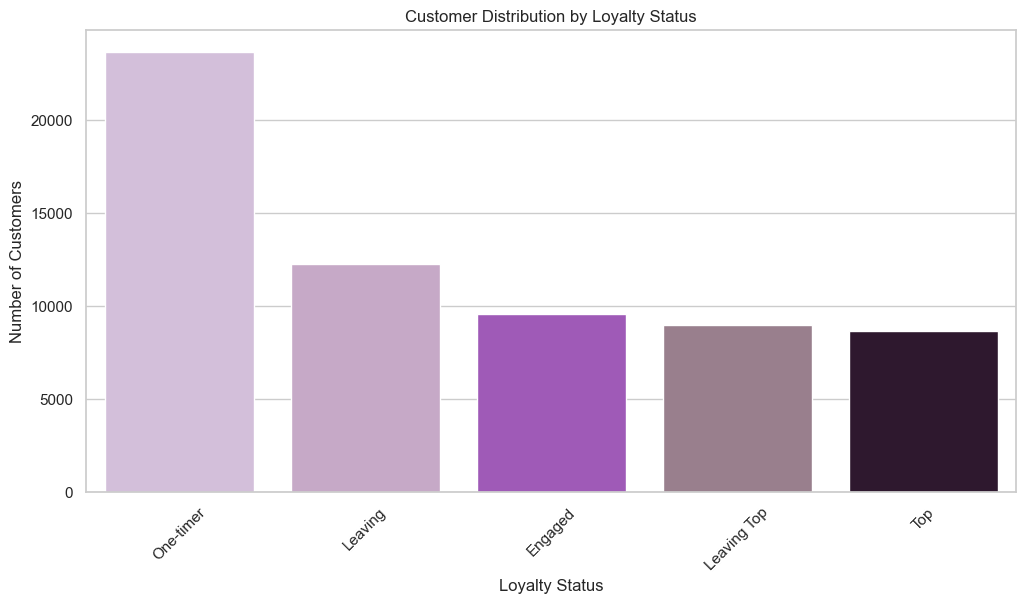

In [15]:
# Funzione per assegnare il loyalty status basato sulla RF-matrix
def loyalty_status(row):
    if row['recency_score'] == 'Low' and row['frequency_score'] == 'High':
        return 'Top'
    elif row['recency_score'] == 'Medium' and row['frequency_score'] == 'High':
        return 'Top'
    elif row['recency_score'] == 'High' and row['frequency_score'] == 'High':
        return 'Leaving Top'
    elif row['recency_score'] == 'Low' and row['frequency_score'] == 'Medium':
        return 'Engaged'
    elif row['recency_score'] == 'Medium' and row['frequency_score'] == 'Medium':
        return 'Engaged'
    elif row['recency_score'] == 'High' and row['frequency_score'] == 'Medium':
        return 'Leaving'
    elif row['recency_score'] == 'Low' and row['frequency_score'] == 'Low':
        return 'One-timer'
    elif row['recency_score'] == 'Medium' and row['frequency_score'] == 'Low':
        return 'One-timer'
    elif row['recency_score'] == 'High' and row['frequency_score'] == 'Low':
        return 'Leaving'
    else:
        return 'Other'

# Applichiamo la funzione per creare la colonna loyalty_status
rfm_active['loyalty_status'] = rfm_active.apply(loyalty_status, axis=1)

# Mappa dei colori per loyalty_status
color_map = {
    'Top': '#311432',
    'Leaving Top': '#9D7B8D',
    'Engaged': '#A74AC7',
    'One-timer': '#D5BADF',
    'Leaving': '#CBA4CC',
    'Other': '#E5D3E8'
}

# Conta il numero di clienti per ciascun loyalty_status
loyalty_status_counts = rfm_active['loyalty_status'].value_counts()

# Crea un barplot
plt.figure(figsize=(12, 6))
sns.barplot(x=loyalty_status_counts.index, y=loyalty_status_counts.values, palette=[color_map[status] for status in loyalty_status_counts.index])
plt.title('Customer Distribution by Loyalty Status')
plt.xlabel('Loyalty Status')
plt.ylabel('Number of Customers')
plt.xticks(rotation=45)
plt.show()


The bar plot shows the distribution of customers across these loyalty statuses, indicating that most customers fall into the 'One-timer' category, followed by 'Leaving', 'Engaged', 'Leaving Top', and 'Top

### Monetary Value groups

The code segment assigns an RFM class to each customer by combining their loyalty status and monetary score. This is achieved through a mapping dictionary that categorizes customers into different RFM classes, such as 'Diamond', 'Gold', 'Silver', 'Bronze', 'Copper', 'Tin', and 'Cheap'. 

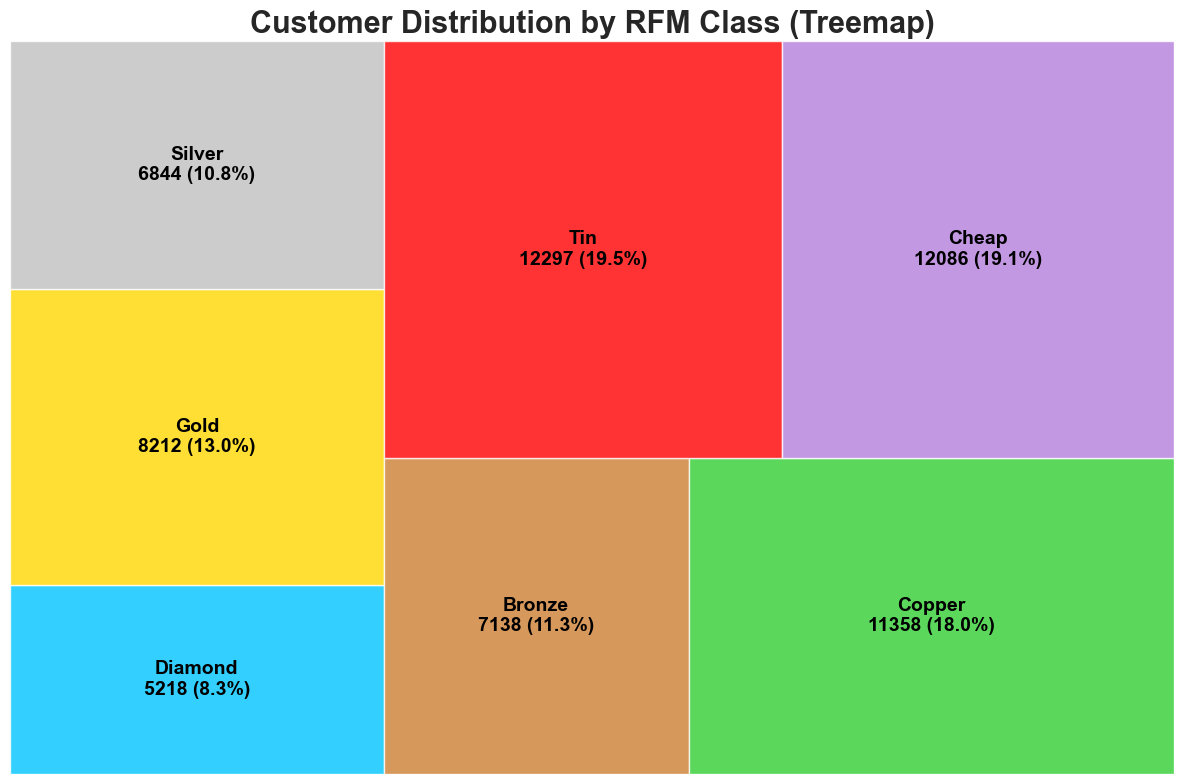

In [16]:
# Dizionario per mappare le combinazioni di loyalty_status e monetary_score alle classi RFM
rfm_mapping = {
    ('Top', 'High'): 'Diamond',
    ('Top', 'Medium'): 'Gold',
    ('Top', 'Low'): 'Silver',
    ('Leaving Top', 'High'): 'Gold',
    ('Leaving Top', 'Medium'): 'Silver',
    ('Leaving Top', 'Low'): 'Bronze',
    ('Engaged', 'High'): 'Silver',
    ('Engaged', 'Medium'): 'Bronze',
    ('Engaged', 'Low'): 'Copper',
    ('Leaving', 'High'): 'Bronze',
    ('Leaving', 'Medium'): 'Copper',
    ('Leaving', 'Low'): 'Tin',
    ('One-timer', 'High'): 'Copper',
    ('One-timer', 'Medium'): 'Tin',
    ('One-timer', 'Low'): 'Cheap'
}

# Funzione per assegnare la classe RFM utilizzando il dizionario di mappatura
def rfm_class(row):
    return rfm_mapping.get((row['loyalty_status'], row['monetary_score']), 'Other')

# Applichiamo la funzione per creare la colonna RFM_Class
rfm_active['RFM_Class'] = rfm_active.apply(rfm_class, axis=1)


# Dizionario per il mapping dei valori RFM a un ordine numerico per garantire l'ordine nel plot
value_order = {
    'Diamond': 1,
    'Gold': 2,
    'Silver': 3,
    'Bronze': 4,
    'Copper': 5,
    'Tin': 6,
    'Cheap': 7
}

# Crea un DataFrame dai conteggi delle classi RFM
rfm_class_counts = rfm_active['RFM_Class'].value_counts().reset_index()
rfm_class_counts.columns = ['RFM_Class', 'Count']

# Mappa i valori RFM a un ordine numerico
rfm_class_counts['Order'] = rfm_class_counts['RFM_Class'].map(value_order)

# Ordina il DataFrame basato sull'ordine numerico
rfm_class_counts = rfm_class_counts.sort_values('Order')

# Mappa dei colori RFM_Class, aggiornata per essere utilizzata nel plot
rfm_color_map = {
    'Diamond': '#00C5FF',   # Blu
    'Gold': '#FFD700',      # Oro
    'Silver': '#C0C0C0',    # Argento
    'Bronze': '#CD7F32',    # Bronzo
    'Copper': '#32CD32',    # Verde chiaro
    'Tin': '#FF0000',       # Rosso
    'Cheap': '#B57EDC'      # Viola
}

# Calcola le percentuali per ciascuna classe RFM
rfm_class_counts['Percentage'] = rfm_class_counts['Count'] / rfm_class_counts['Count'].sum() * 100

# Crea le etichette combinate con il nome della classe e la percentuale
labels = [f"{cls}\n{count} ({percentage:.1f}%)" for cls, count, percentage in zip(rfm_class_counts['RFM_Class'], rfm_class_counts['Count'], rfm_class_counts['Percentage'])]

# Impostazioni di visualizzazione
plt.figure(figsize=(12, 8))
sns.set(style="white")

# Creazione del treemap con miglioramenti nel layout e nelle etichette
squarify.plot(
    sizes=rfm_class_counts['Count'], 
    label=labels, 
    color=[rfm_color_map[cls] for cls in rfm_class_counts['RFM_Class']], 
    alpha=0.8, 
    text_kwargs={'fontsize': 14, 'weight': 'bold', 'color': 'black'}
)

# Aggiunta del titolo
plt.title('Customer Distribution by RFM Class (Treemap)', fontsize=22, weight='bold')

# Rimozione dell'asse per un look pulito
plt.axis('off')

# Mostra il grafico
plt.tight_layout()
plt.show()

The bar plot shows the distribution of customers across these RFM classes, indicating that most customers fall into the 'Tin' and 'Cheap' categories, with fewer customers in the higher-value 'Diamond' and 'Gold' classes.

## Churn Analysis

The objective of this analysis is to examine various customer purchasing behaviors to understand the main factors contributing to churn. Customer churn, or customer attrition, is a significant challenge for businesses, as it represents the loss of clients or customers over time. By identifying the key drivers of churn, businesses can develop targeted strategies to retain customers and improve their overall customer experience.

##### Approach

To achieve this, we will train several machine learning models to predict customer churn based on their purchasing behaviors and other relevant features. The models will help us identify which factors have the most significant impact on whether a customer is likely to churn.

##### Steps

1. **Data Preparation**: Load and preprocess the data, ensuring it is clean and ready for modeling.
2. **Feature Engineering**: Create new features and transform existing ones to better capture the underlying patterns in the data.
3. **Model Training**: Train various machine learning models to predict churn.
4. **Model Evaluation**: Evaluate the performance of the models using appropriate metrics such as accuracy, recall, precision, and F1-score.
5. **Interpretation**: Interpret the results to understand the key factors influencing churn.

Load the datasets and merge the `customers` dataset with the `customer_accounts` dataset on `customer_id` to create a unified dataset. Check for and remove any duplicate `customer_id` entries.







### Data Loading

In [17]:
# Load the datasets
orders = pd.read_csv(TBL_ORDERS_PATH)
customers = pd.read_csv(TBL_CUSTOMERS_PATH)
customer_accounts = pd.read_csv(TBL_CUSTOMER_ACCOUNTS_PATH)

### Data Preparation

In [18]:
# Merge the customers and customer_accounts datasets on 'customer_id'
merged_data = pd.merge(customers, customer_accounts, on='customer_id', how='inner')

# Check for duplicates in 'customer_id'
duplicates = merged_data[merged_data.duplicated('customer_id', keep=False)]
print(f"Number of duplicate customer_id entries: {duplicates.shape[0]}")

# Display and remove the duplicate entries if any
if not duplicates.empty:
    # Remove duplicates by keeping the first occurrence
    merged_data = merged_data.drop_duplicates('customer_id')
    print("\nDuplicates removed.")



Number of duplicate customer_id entries: 606

Duplicates removed.


Perform an inner join between the `rfm_active` dataset and the `merged_data` dataset on `customer_id` to include only those customers who are actively segmented in the RFM analysis. This step ensures that we are focusing on customers who have been actively engaged and categorized based on their recency, frequency, and monetary values.


In [19]:
rfm_churn_data = pd.merge(rfm_active, merged_data, on='customer_id', how='inner')

# Display the first few rows of the merged dataset
print("Merged Data (RFM + Churn Status):")
rfm_churn_data.head()

Merged Data (RFM + Churn Status):


,customer_id,recency,frequency,monetary,recency_score,frequency_score,monetary_score,loyalty_status,RFM_Class,address_id,...,gender,job_type,email_provider,flag_phone_provided,flag_privacy,account_id,favorite_store,loyalty_type,loyatlty_status,activation_date
0,23,69,7,490.60,Medium,High,High,Top,Diamond,21,...,F,NaN,gmail.com,1.0,True,512658,49,standard,1,2022-09-08
1,30,281,2,10179.56,Low,Low,High,One-timer,Copper,29,...,F,NaN,gmail.com,NaN,True,351603,49,premium,1,2022-06-11
2,32,28,3,58.85,High,Low,Low,Leaving,Tin,31,...,M,NaN,hotmail.it,1.0,True,849471,49,business premium,1,2023-03-15
3,48,23,14,1577.33,High,High,High,Leaving Top,Gold,46,...,M,self-employed,alice.it,1.0,True,456894,49,premium,1,2022-08-08
4,50,70,2,28.75,Medium,Low,Low,One-timer,Cheap,48,...,F,NaN,gmail.com,1.0,True,668686,49,premium,1,2022-11-23


Calculate the last purchase date for each eligible customer by filtering orders with `direction` equal to 1. Ensure the last purchase date is in datetime format. Perform an inner join to merge this last purchase date with the `rfm_churn_data` dataset, focusing only on customers who are eligible based on their purchase history. Display the updated dataset to verify the incorporation of the last purchase date.


In [20]:
# Calculate the last purchase date for each eligible customer
purchase_orders = orders[orders['direction'] == 1]

last_purchase_date = purchase_orders.groupby('customer_id')['purchase_datetime'].max().reset_index()
last_purchase_date.columns = ['customer_id', 'last_purchase_date']

# Ensure the last_purchase_date is in datetime format
last_purchase_date['last_purchase_date'] = pd.to_datetime(last_purchase_date['last_purchase_date'])

# Perform an inner join to merge the last purchase date with the merged_data
rfm_churn_data = pd.merge(rfm_churn_data, last_purchase_date, on='customer_id', how='inner')

# Display the first few rows of the updated merged_data
print("Merged Data with Last Purchase Date for Eligible Customers:")
rfm_churn_data.head()


Merged Data with Last Purchase Date for Eligible Customers:


,customer_id,recency,frequency,monetary,recency_score,frequency_score,monetary_score,loyalty_status,RFM_Class,address_id,...,job_type,email_provider,flag_phone_provided,flag_privacy,account_id,favorite_store,loyalty_type,loyatlty_status,activation_date,last_purchase_date
0,23,69,7,490.60,Medium,High,High,Top,Diamond,21,...,NaN,gmail.com,1.0,True,512658,49,standard,1,2022-09-08,2023-02-20 11:51:51
1,30,281,2,10179.56,Low,Low,High,One-timer,Copper,29,...,NaN,gmail.com,NaN,True,351603,49,premium,1,2022-06-11,2022-07-23 07:06:38
2,32,28,3,58.85,High,Low,Low,Leaving,Tin,31,...,NaN,hotmail.it,1.0,True,849471,49,business premium,1,2023-03-15,2023-04-02 15:11:58
3,48,23,14,1577.33,High,High,High,Leaving Top,Gold,46,...,self-employed,alice.it,1.0,True,456894,49,premium,1,2022-08-08,2023-04-30 19:35:36
4,50,70,2,28.75,Medium,Low,Low,One-timer,Cheap,48,...,NaN,gmail.com,1.0,True,668686,49,premium,1,2022-11-23,2023-02-19 16:56:32


In [21]:
len(rfm_churn_data)

63153

Define the churn status of customers based on the inactivity threshold derived from the RFM analysis. This involves calculating how long it has been since their last purchase and determining if they are considered churned. Display the results to understand the distribution of churned versus active customers.


In [22]:
# Define the reference date for churn calculation
reference_date = pd.to_datetime('2023-05-01')

# Determine churn status
rfm_churn_data['churn'] = (reference_date - rfm_churn_data['last_purchase_date']).dt.days > inactivity_threshold

# Display the churn status distribution
print("\nChurn Status Distribution:")
print(rfm_churn_data['churn'].value_counts())

# Display the first few rows of the final dataset
print("\nFinal Dataset with Churn Status:")
rfm_churn_data.head()



Churn Status Distribution:
churn
False    34146
True     29007
Name: count, dtype: int64

Final Dataset with Churn Status:


,customer_id,recency,frequency,monetary,recency_score,frequency_score,monetary_score,loyalty_status,RFM_Class,address_id,...,email_provider,flag_phone_provided,flag_privacy,account_id,favorite_store,loyalty_type,loyatlty_status,activation_date,last_purchase_date,churn
0,23,69,7,490.60,Medium,High,High,Top,Diamond,21,...,gmail.com,1.0,True,512658,49,standard,1,2022-09-08,2023-02-20 11:51:51,False
1,30,281,2,10179.56,Low,Low,High,One-timer,Copper,29,...,gmail.com,NaN,True,351603,49,premium,1,2022-06-11,2022-07-23 07:06:38,True
2,32,28,3,58.85,High,Low,Low,Leaving,Tin,31,...,hotmail.it,1.0,True,849471,49,business premium,1,2023-03-15,2023-04-02 15:11:58,False
3,48,23,14,1577.33,High,High,High,Leaving Top,Gold,46,...,alice.it,1.0,True,456894,49,premium,1,2022-08-08,2023-04-30 19:35:36,False
4,50,70,2,28.75,Medium,Low,Low,One-timer,Cheap,48,...,gmail.com,1.0,True,668686,49,premium,1,2022-11-23,2023-02-19 16:56:32,False


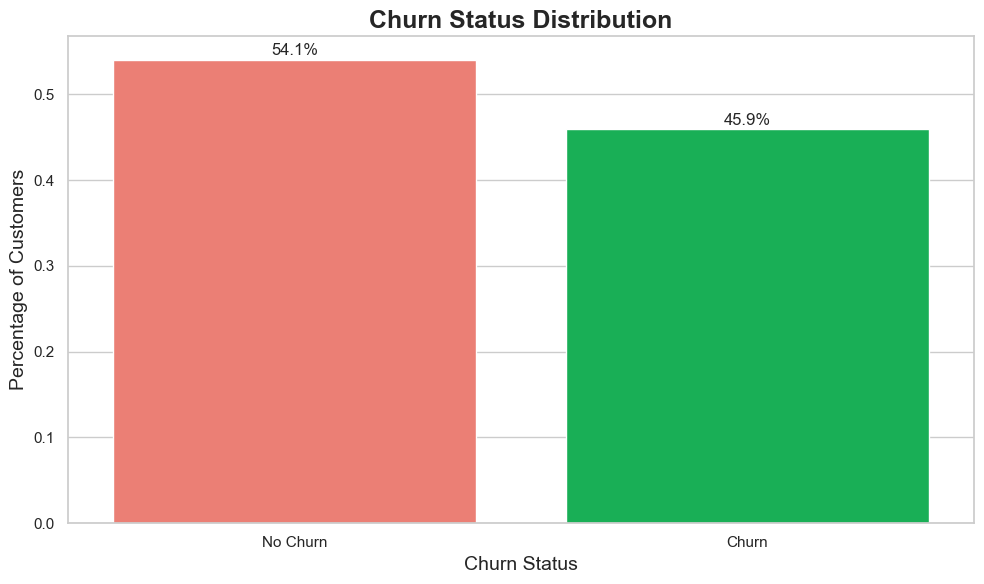

In [23]:
# Calcola la distribuzione del churn
churn_counts = rfm_churn_data['churn'].value_counts(normalize=True).reset_index()  # Calcola le percentuali
churn_counts.columns = ['Churn Status', 'Percentage']

# Converti il Churn Status in un formato leggibile (True/False -> Churn/No Churn)
churn_counts['Churn Status'] = churn_counts['Churn Status'].map({True: 'Churn', False: 'No Churn'})

# Imposta una palette di colori personalizzata
churn_palette = ['#FF6F61', '#00C851']  # Rosso per churn, verde per no churn

# Crea il grafico a barre
plt.figure(figsize=(10, 6))
sns.set(style="whitegrid")  # Design pulito e professionale
sns.barplot(x='Churn Status', y='Percentage', data=churn_counts, palette=churn_palette)

# Aggiungi annotazioni con le percentuali esatte sopra le barre
for i, percentage in enumerate(churn_counts['Percentage']):
    plt.text(i, percentage + churn_counts['Percentage'].max() * 0.01, f'{percentage:.1%}', ha='center', fontsize=12)

# Aggiungi titoli e etichette
plt.title('Churn Status Distribution', fontsize=18, weight='bold')
plt.xlabel('Churn Status', fontsize=14)
plt.ylabel('Percentage of Customers', fontsize=14)

# Mostra il grafico con un layout pulito
plt.tight_layout()
plt.show()

The churn status distribution indicates that out of the total customers, 34,146 are still active (False) while 29,007 have churned (True). This relatively balanced distribution suggests that the dataset is suitable for building predictive models, as both classes (churned and active) are well-represented. This balance can help improve the robustness and reliability of our churn prediction model.


In [24]:
# Select only the required columns
rfm_churn_selected = rfm_churn_data[['customer_id', 'frequency_score', 'monetary_score', 'gender', 'churn']]

# Display the first few rows of the selected columns
print("Selected Columns Data:")
print(rfm_churn_selected.head())


Selected Columns Data:
   customer_id frequency_score monetary_score gender  churn
0           23            High           High      F  False
1           30             Low           High      F   True
2           32             Low            Low      M  False
3           48            High           High      M  False
4           50             Low            Low      F  False


Selected the necessary variables for analysis, excluding `recency_score` because churn is calculated based on recency (last purchase). Including `recency_score` could bias the model and prevent us from focusing on other important factors influencing churn.


### Feature engineering

Perform feature engineering to create additional variables that help in understanding customer behavior and predicting churn. The key features created are:

- `is_reviewer`: Indicates whether a customer has ever left a review. This binary feature helps in understanding if engagement through reviews correlates with churn.
- `has_refunded`: Indicates whether a customer has ever made a refund. This binary feature is important for understanding the impact of negative experiences on churn.
- `num_unique_products_purchased`: The total number of unique products purchased by each customer. This feature is segmented into tertiles (`num_unique_products_purchased_score`) to classify customers based on their diversity in purchases.
- `percentage_discounted_products`: The percentage of products purchased at a discount. This feature helps to understand if customers who frequently buy discounted products are more likely to churn.
- `order_avg_monetary`: The average monetary value per order for each customer. This feature is segmented into tertiles (`order_avg_monetary_score`) to categorize customers based on their spending per order.
- `avg_order_num_products`: The average number of unique products per order for each customer. This feature is segmented into tertiles (`avg_order_num_products_score`) to classify customers based on the variety of products they purchase in each order.
- `total_products_purchased`: The total number of products purchased by each customer. This feature is segmented into tertiles (`total_products_purchased_score`) to classify customers based on their overall purchase volume.

The scoring (binning into tertiles) is primarily done to handle different outliers, as observed from the distributions of `frequency` and `monetary` scores. By using binning, we manage outliers effectively and ensure that the model is not unduly influenced by extreme values.


In [25]:
# Calculate is_reviewer
is_reviewer = customer_reviews['customer_id'].unique()
rfm_churn_selected['is_reviewer'] = rfm_churn_selected['customer_id'].isin(is_reviewer)

# Calculate has_refunded
refund_orders = orders[orders['direction'] == -1]['customer_id'].unique()
rfm_churn_selected['has_refunded'] = rfm_churn_selected['customer_id'].isin(refund_orders)

# Calculate numero_di_prodotti_acquistati_diversi
distinct_products = orders[orders['direction'] == 1].groupby('customer_id')['product_id'].nunique().reset_index()
distinct_products.columns = ['customer_id', 'num_unique_products_purchased']
rfm_churn_selected = pd.merge(rfm_churn_selected, distinct_products, on='customer_id', how='left')

# Divide num_unique_products_purchased into tertiles (Low, Medium, High)
rfm_churn_selected['num_unique_products_purchased_score'] = pd.qcut(rfm_churn_selected['num_unique_products_purchased'], 3, labels=['Low', 'Medium', 'High'])

# Calculate percentage_discounted_products
discounted_products = orders[(orders['direction'] == 1) & (orders['price_reduction'] != 0)].groupby('customer_id').size().reset_index(name='discounted_count')
total_products = orders[orders['direction'] == 1].groupby('customer_id').size().reset_index(name='total_count')
discount_percentage = pd.merge(total_products, discounted_products, on='customer_id', how='left')
discount_percentage['discounted_count'] = discount_percentage['discounted_count'].fillna(0)
discount_percentage['percentage_discounted_products'] = discount_percentage['discounted_count'] / discount_percentage['total_count']

rfm_churn_selected = pd.merge(rfm_churn_selected, discount_percentage[['customer_id', 'percentage_discounted_products']], on='customer_id', how='left')

# Calculate the average monetary value per order for each customer
order_values = orders[orders['direction'] == 1].groupby(['customer_id', 'order_id'])['gross_price'].sum().reset_index()
avg_order_value = order_values.groupby('customer_id')['gross_price'].mean().reset_index()
avg_order_value.columns = ['customer_id', 'order_avg_monetary']

# Merge with the main DataFrame
rfm_churn_selected = pd.merge(rfm_churn_selected, avg_order_value, on='customer_id', how='left')

# Divide the distribution into tertiles (Low, Medium, High)
rfm_churn_selected['order_avg_monetary_score'] = pd.qcut(rfm_churn_selected['order_avg_monetary'], 3, labels=['Low', 'Medium', 'High'])

# Calculate the average number of unique products per order for each customer
unique_products_per_order = orders[orders['direction'] == 1].groupby(['customer_id', 'order_id'])['product_id'].nunique().reset_index()
avg_unique_products_per_order = unique_products_per_order.groupby('customer_id')['product_id'].mean().reset_index()
avg_unique_products_per_order.columns = ['customer_id', 'avg_order_num_products']

# Merge with the main DataFrame
rfm_churn_selected = pd.merge(rfm_churn_selected, avg_unique_products_per_order, on='customer_id', how='left')

# Divide avg_order_num_products into tertiles (Low, Medium, High)
rfm_churn_selected['avg_order_num_products_score'] = pd.qcut(rfm_churn_selected['avg_order_num_products'], 3, labels=['Low', 'Medium', 'High'])

# Calculate total number of products purchased per customer
total_products_purchased = orders[orders['direction'] == 1].groupby('customer_id')['product_id'].size().reset_index()
total_products_purchased.columns = ['customer_id', 'total_products_purchased']
rfm_churn_selected = pd.merge(rfm_churn_selected, total_products_purchased, on='customer_id', how='left')

# Divide total_products_purchased into tertiles (Low, Medium, High)
rfm_churn_selected['total_products_purchased_score'] = pd.qcut(rfm_churn_selected['total_products_purchased'], 3, labels=['Low', 'Medium', 'High'])

rfm_churn_selected


,customer_id,frequency_score,monetary_score,gender,churn,is_reviewer,has_refunded,num_unique_products_purchased,num_unique_products_purchased_score,percentage_discounted_products,order_avg_monetary,order_avg_monetary_score,avg_order_num_products,avg_order_num_products_score,total_products_purchased,total_products_purchased_score
0,23,High,High,F,False,True,True,34,High,0.243243,70.085714,High,5.142857,High,37,High
1,30,Low,High,F,True,False,False,4,Low,1.000000,5089.780000,High,2.000000,Medium,12,Medium
2,32,Low,Low,M,False,True,False,11,Medium,0.000000,19.616667,Medium,3.666667,High,11,Medium
3,48,High,High,M,False,False,True,33,High,0.326923,105.685333,High,3.466667,High,52,High
4,50,Low,Low,F,False,True,False,4,Low,0.500000,14.375000,Low,2.000000,Medium,4,Low
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
63148,927433,Low,Medium,M,False,True,False,12,High,0.230769,86.280000,High,6.000000,High,13,Medium
63149,927464,Low,Medium,M,False,True,False,4,Low,0.000000,71.855000,High,2.000000,Medium,4,Low
63150,927548,Low,Medium,F,False,False,True,9,Medium,0.000000,64.045000,High,4.500000,High,9,Medium
63151,927923,Low,Medium,F,False,True,False,5,Low,0.000000,32.845000,Medium,3.000000,High,6,Low


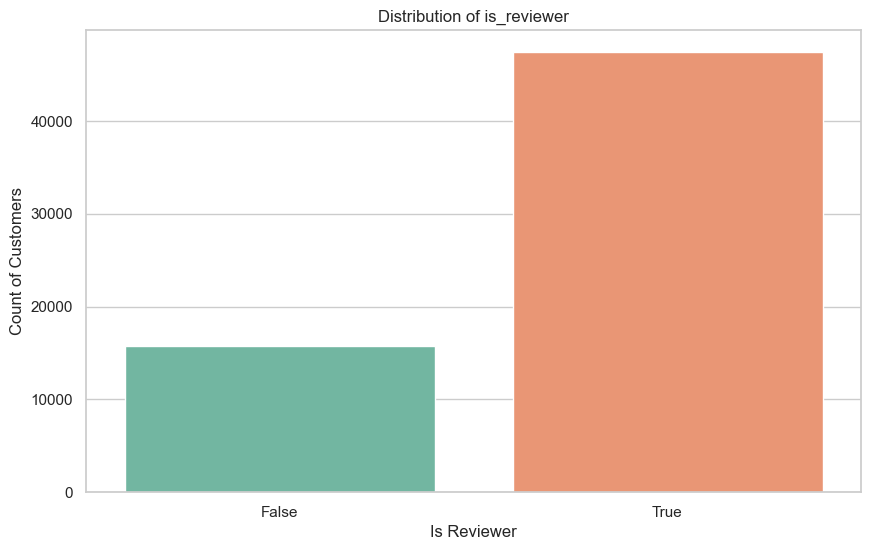

In [26]:
# Plot the distribution of is_reviewer
plt.figure(figsize=(10, 6))
sns.countplot(data=rfm_churn_selected, x='is_reviewer', palette='Set2')
plt.title('Distribution of is_reviewer')
plt.xlabel('Is Reviewer')
plt.ylabel('Count of Customers')
plt.xticks([0, 1], ['False', 'True'])
plt.show()


The plot shows the distribution of the `is_reviewer` feature, indicating the number of customers who have left at least one review (`True`) versus those who have not (`False`). The majority of customers have left reviews, which suggests that a significant portion of the customer base is engaged enough to provide feedback.

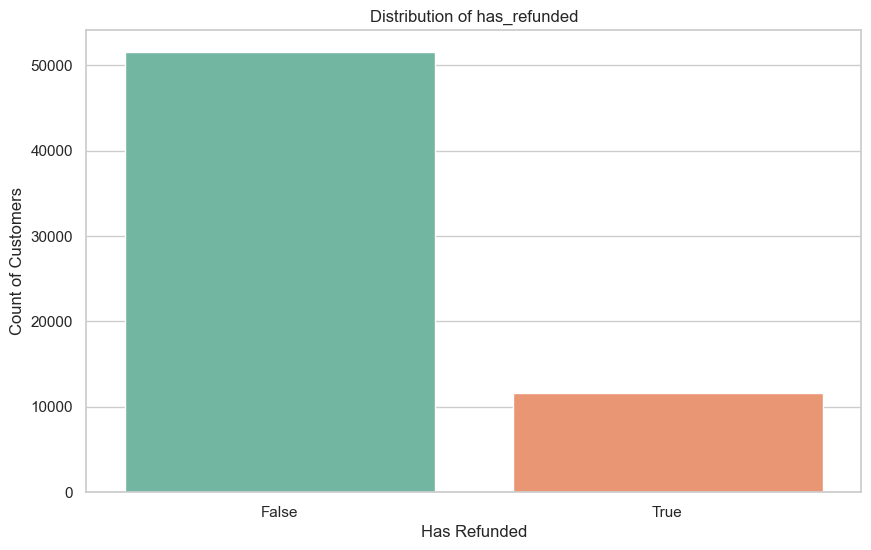

In [27]:
# Plot the distribution of has_refunded
plt.figure(figsize=(10, 6))
sns.countplot(data=rfm_churn_selected, x='has_refunded', palette='Set2')
plt.title('Distribution of has_refunded')
plt.xlabel('Has Refunded')
plt.ylabel('Count of Customers')
plt.xticks([0, 1], ['False', 'True'])
plt.show()


The plot displays the distribution of the `has_refunded` feature, showing the count of customers who have made at least one refund (`True`) versus those who have not (`False`). The majority of customers have not made any refunds, while a smaller proportion has. This indicates that while refunds are relatively infrequent, they are an important aspect to consider in the analysis as they might impact customer satisfaction and churn behavior.


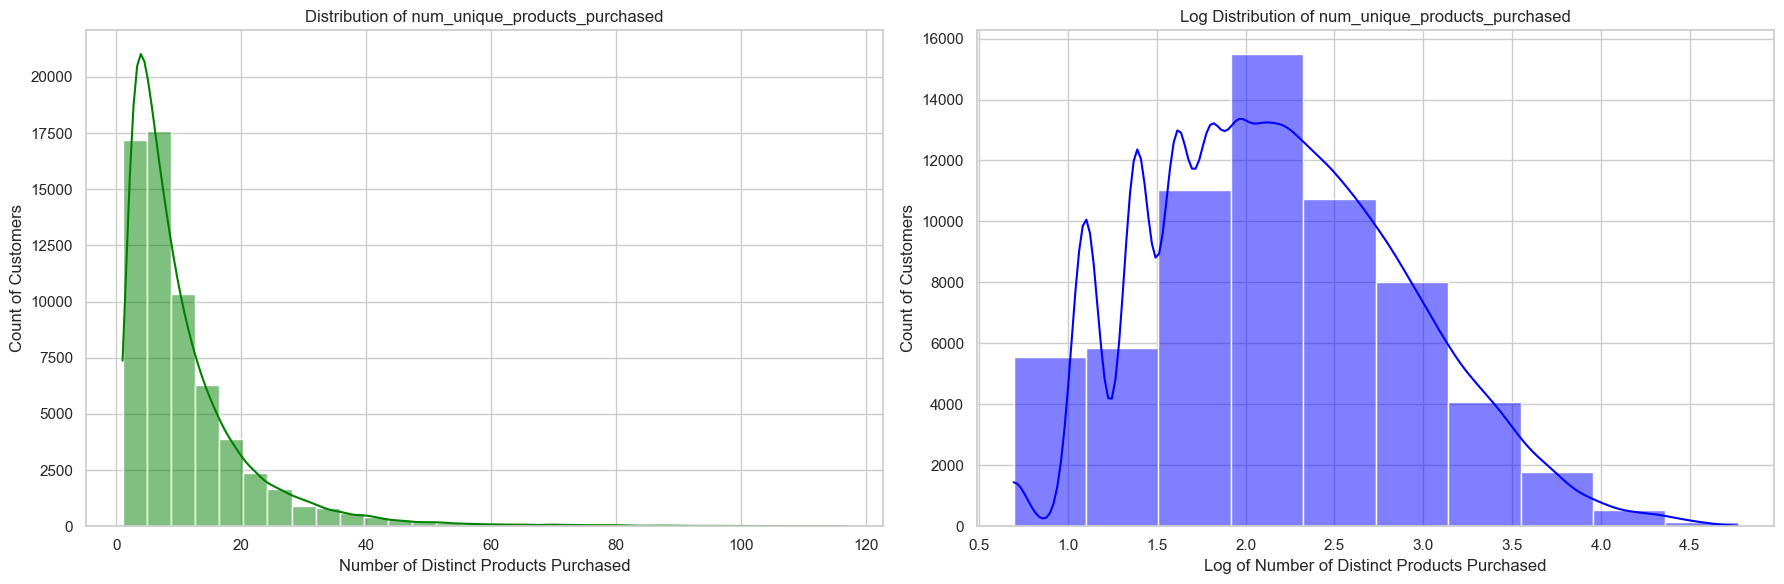

In [28]:
rfm_churn_selected['log_num_unique_products_purchased'] = np.log1p(rfm_churn_selected['num_unique_products_purchased'])

# Plot the original and logarithmic distributions side by side
fig, axes = plt.subplots(1, 2, figsize=(18, 6))

# Original distribution
sns.histplot(data=rfm_churn_selected, x='num_unique_products_purchased', kde=True, bins=30, color='green', ax=axes[0])
axes[0].set_title('Distribution of num_unique_products_purchased')
axes[0].set_xlabel('Number of Distinct Products Purchased')
axes[0].set_ylabel('Count of Customers')

# Logarithmic distribution
sns.histplot(data=rfm_churn_selected, x='log_num_unique_products_purchased', kde=True, bins=10, color='blue', ax=axes[1])
axes[1].set_title('Log Distribution of num_unique_products_purchased')
axes[1].set_xlabel('Log of Number of Distinct Products Purchased')
axes[1].set_ylabel('Count of Customers')

plt.tight_layout()
plt.show()

The plots display the distribution of the `num_unique_products_purchased` feature. 

- **Left Plot**: Shows the original distribution of the number of distinct products purchased by each customer. The distribution is highly skewed to the right, indicating that most customers purchase a small number of unique products, while a few purchase a large variety.

- **Right Plot**: Shows the log-transformed distribution of the number of distinct products purchased. Applying a logarithmic transformation makes the distribution more normal (bell-shaped). This transformation helps in normalizing the skewed data and can improve the performance and interpretation of machine learning models by reducing the impact of extreme outliers.


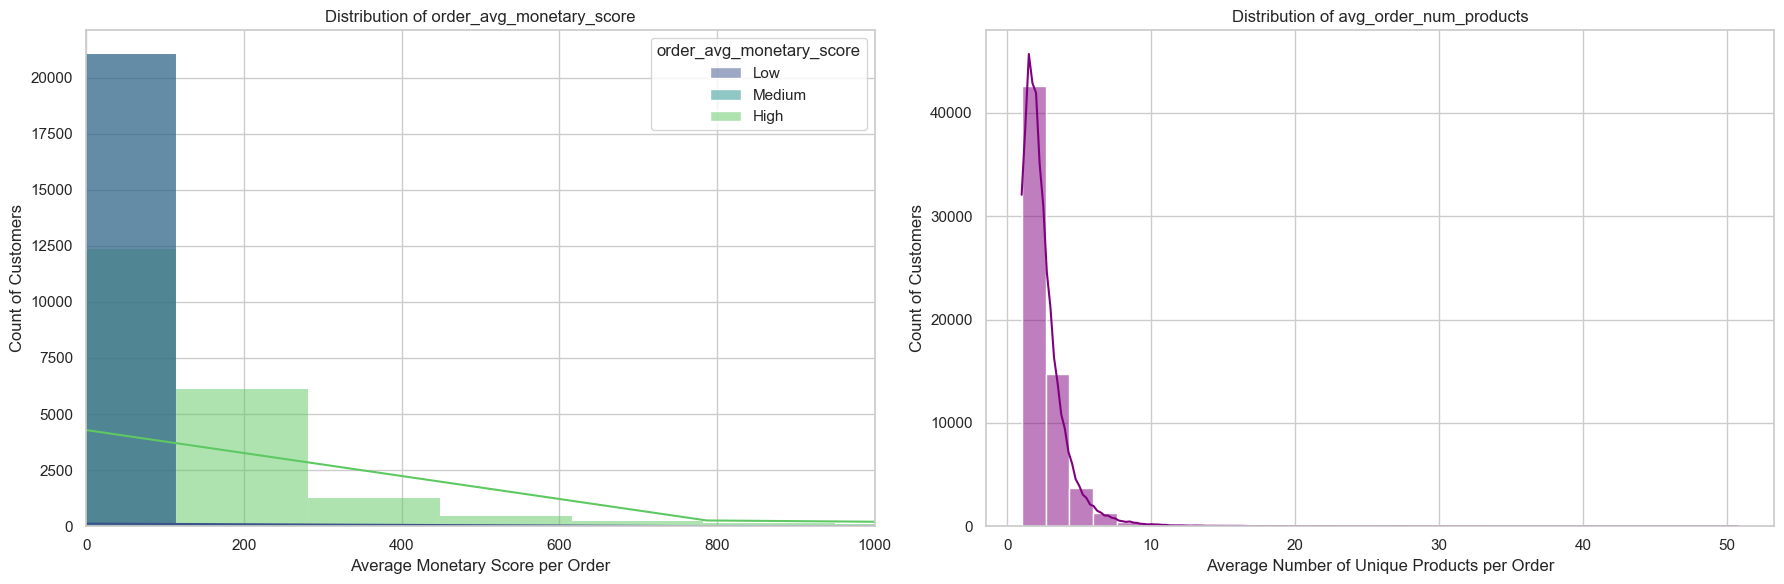

In [29]:


# Plot the distribution of order_avg_monetary_score
fig, axes = plt.subplots(1, 2, figsize=(18, 6))

# Distribution of order_avg_monetary_score
sns.histplot(data=rfm_churn_selected, x='order_avg_monetary', kde=True, bins=1000, ax=axes[0], hue='order_avg_monetary_score', palette='viridis')
axes[0].set_title('Distribution of order_avg_monetary_score')
axes[0].set_xlabel('Average Monetary Score per Order')
axes[0].set_ylabel('Count of Customers')
axes[0].set_xlim(0, 1000)  # Set x-axis limits


# Distribution of avg_order_num_products
sns.histplot(data=rfm_churn_selected, x='avg_order_num_products', kde=True, bins=30, color='purple', ax=axes[1])
axes[1].set_title('Distribution of avg_order_num_products')
axes[1].set_xlabel('Average Number of Unique Products per Order')
axes[1].set_ylabel('Count of Customers')

plt.tight_layout()
plt.show()


The plots display the distributions of the `order_avg_monetary_score` and `avg_order_num_products` features.

- **Left Plot**: Shows the distribution of the average monetary value per order (`order_avg_monetary_score`) segmented into tertiles (Low, Medium, High). 

- **Right Plot**: Shows the distribution of the average number of unique products per order (`avg_order_num_products`). The distribution is highly skewed to the right, indicating that most customers purchase a small number of unique products per order, with a few customers purchasing a larger variety. This skewed distribution suggests the presence of outliers and might benefit from a transformation to normalize the data.

Both features show significant right skewness, which is typical in retail data where a few customers tend to have much higher spending or purchasing behavior than the majority. These features are important for understanding customer purchasing patterns and their impact on churn.


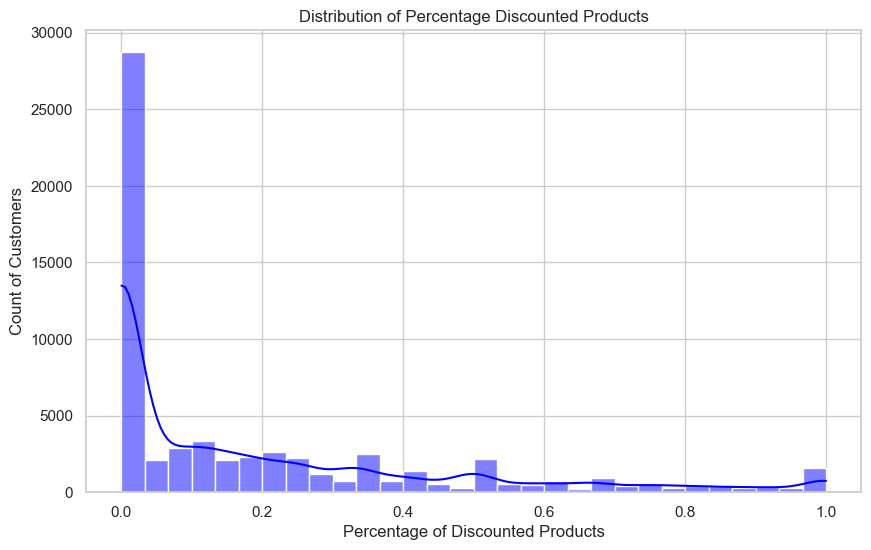

In [30]:
# Plot the distribution of percentage_discounted_products
plt.figure(figsize=(10, 6))
sns.histplot(data=rfm_churn_selected, x='percentage_discounted_products', kde=True, bins=30, color='blue')
plt.title('Distribution of Percentage Discounted Products')
plt.xlabel('Percentage of Discounted Products')
plt.ylabel('Count of Customers')
plt.show()


The plot shows the distribution of the `percentage_discounted_products` feature, which represents the proportion of products purchased at a discount by each customer. The distribution is highly skewed to the right, with the majority of customers purchasing very few or no discounted products. There are fewer customers who purchase a higher percentage of discounted products. This skewness suggests that most customers do not heavily rely on discounts for their purchases, while a smaller segment of the customer base takes advantage of discounts more frequently. This feature can help us understand if a tendency to buy discounted products is related to churn behavior.


In [31]:
# Define the function to categorize customers based on percentage of discounted products
def categorize_discounted_products(row):
    if row['percentage_discounted_products'] == 0:
        return 'Never'
    elif row['percentage_discounted_products'] == 1:
        return 'Always'
    else:
        return 'Sometimes'

# Apply the function to create a new column
rfm_churn_selected['discounted_purchase_category'] = rfm_churn_selected.apply(categorize_discounted_products, axis=1)

# Display the first few rows of the updated dataset
print("Updated Dataset with Discounted Purchase Category:")
print(rfm_churn_selected.head())


Updated Dataset with Discounted Purchase Category:
   customer_id frequency_score monetary_score gender  churn  is_reviewer  \
0           23            High           High      F  False         True   
1           30             Low           High      F   True        False   
2           32             Low            Low      M  False         True   
3           48            High           High      M  False        False   
4           50             Low            Low      F  False         True   

   has_refunded  num_unique_products_purchased  \
0          True                             34   
1         False                              4   
2         False                             11   
3          True                             33   
4         False                              4   

  num_unique_products_purchased_score  percentage_discounted_products  \
0                                High                        0.243243   
1                                 Low        

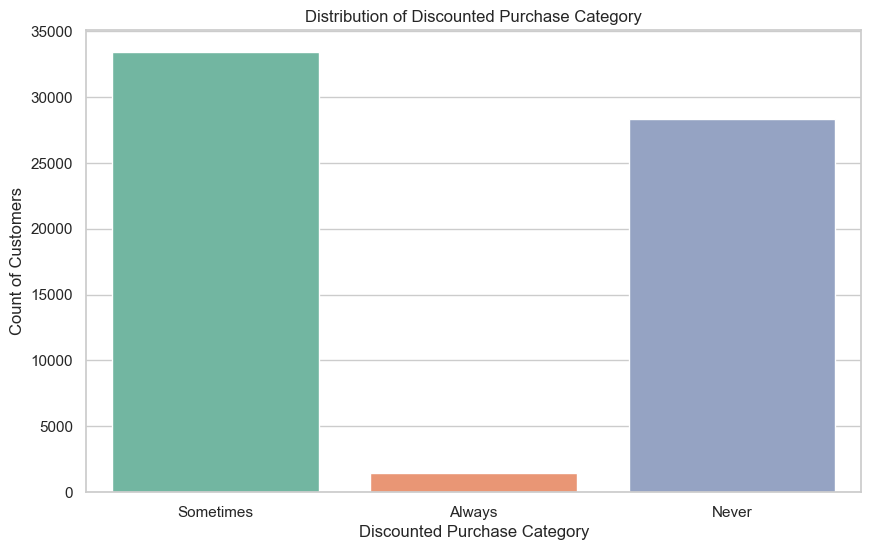

In [32]:
# Plot the distribution of discounted_purchase_category
plt.figure(figsize=(10, 6))
sns.countplot(data=rfm_churn_selected, x='discounted_purchase_category', palette='Set2')
plt.title('Distribution of Discounted Purchase Category')
plt.xlabel('Discounted Purchase Category')
plt.ylabel('Count of Customers')
plt.show()


The plot displays the distribution of the `discounted_purchase_category` feature, which categorizes customers based on their percentage of discounted product purchases into three groups: `Never`, `Sometimes`, and `Always`.

- **Never**: Customers who never purchase discounted products. This category represents a significant portion of the customer base, indicating a preference for non-discounted items.
- **Sometimes**: Customers who purchase discounted products occasionally. This is the largest category, suggesting that most customers take advantage of discounts sporadically.
- **Always**: Customers who always purchase discounted products. This is a very small segment of the customer base, indicating that very few customers exclusively buy discounted items.

This categorization helps in understanding different customer behaviors regarding discounts and can provide insights into how discount strategies might influence churn rates.


In [33]:
rfm_churn_selected.columns

Index(['customer_id', 'frequency_score', 'monetary_score', 'gender', 'churn',
       'is_reviewer', 'has_refunded', 'num_unique_products_purchased',
       'num_unique_products_purchased_score', 'percentage_discounted_products',
       'order_avg_monetary', 'order_avg_monetary_score',
       'avg_order_num_products', 'avg_order_num_products_score',
       'total_products_purchased', 'total_products_purchased_score',
       'log_num_unique_products_purchased', 'discounted_purchase_category'],
      dtype='object')

In [34]:
# Adding all necessary scores to the final DataFrame
rfm_final = rfm_churn_selected[['frequency_score', 'monetary_score', 'gender', 'churn', 'is_reviewer', 'has_refunded',
                                'discounted_purchase_category', 
                                'num_unique_products_purchased_score', 'order_avg_monetary_score', 
                              'avg_order_num_products_score', 
                                 'total_products_purchased_score']]

rfm_final


,frequency_score,monetary_score,gender,churn,is_reviewer,has_refunded,discounted_purchase_category,num_unique_products_purchased_score,order_avg_monetary_score,avg_order_num_products_score,total_products_purchased_score
0,High,High,F,False,True,True,Sometimes,High,High,High,High
1,Low,High,F,True,False,False,Always,Low,High,Medium,Medium
2,Low,Low,M,False,True,False,Never,Medium,Medium,High,Medium
3,High,High,M,False,False,True,Sometimes,High,High,High,High
4,Low,Low,F,False,True,False,Sometimes,Low,Low,Medium,Low
...,...,...,...,...,...,...,...,...,...,...,...
63148,Low,Medium,M,False,True,False,Sometimes,High,High,High,Medium
63149,Low,Medium,M,False,True,False,Never,Low,High,Medium,Low
63150,Low,Medium,F,False,False,True,Never,Medium,High,High,Medium
63151,Low,Medium,F,False,True,False,Never,Low,Medium,High,Low


### Preprocessing

#### Ordinal

In [35]:

# Define the order for ordinal encoding
frequency_order = ['Low', 'Medium', 'High']
monetary_order = ['Low', 'Medium', 'High']
avg_monetary_order = ['Low', 'Medium', 'High']
unique_products_order = ['Low', 'Medium', 'High']
avg_order_products_order = ['Low', 'Medium', 'High']
total_products_order = ['Low', 'Medium', 'High']
discounted_purchase_order = ['Never', 'Sometimes','Always']
# Instantiate the OrdinalEncoder with specified order
ordinal_encoder = OrdinalEncoder(categories=[
    frequency_order, 
    monetary_order, 
    avg_monetary_order, 
    unique_products_order, 
    avg_order_products_order, 
    total_products_order,discounted_purchase_order])

# Apply the encoding to the ordinal columns
ordinal_columns = [
    'frequency_score', 
    'monetary_score', 
    'order_avg_monetary_score', 
    'num_unique_products_purchased_score', 
    'avg_order_num_products_score', 
    'total_products_purchased_score',
    'discounted_purchase_category']

rfm_final[ordinal_columns] = ordinal_encoder.fit_transform(rfm_final[ordinal_columns])

# Display the first few rows of the encoded dataset
print("Encoded Dataset:")
rfm_final.head()


Encoded Dataset:


,frequency_score,monetary_score,gender,churn,is_reviewer,has_refunded,discounted_purchase_category,num_unique_products_purchased_score,order_avg_monetary_score,avg_order_num_products_score,total_products_purchased_score
0,2.0,2.0,F,False,True,True,1.0,2.0,2.0,2.0,2.0
1,0.0,2.0,F,True,False,False,2.0,0.0,2.0,1.0,1.0
2,0.0,0.0,M,False,True,False,0.0,1.0,1.0,2.0,1.0
3,2.0,2.0,M,False,False,True,1.0,2.0,2.0,2.0,2.0
4,0.0,0.0,F,False,True,False,1.0,0.0,0.0,1.0,0.0


#### Binary

In [36]:
rfm_final['churn'] = rfm_final['churn'].astype(int)
rfm_final['is_reviewer'] = rfm_final['is_reviewer'].astype(int)
rfm_final['has_refunded'] = rfm_final['has_refunded'].astype(int)

# Display the first few rows of the encoded dataset
print("Encoded Dataset:")
rfm_final.head()

Encoded Dataset:


,frequency_score,monetary_score,gender,churn,is_reviewer,has_refunded,discounted_purchase_category,num_unique_products_purchased_score,order_avg_monetary_score,avg_order_num_products_score,total_products_purchased_score
0,2.0,2.0,F,0,1,1,1.0,2.0,2.0,2.0,2.0
1,0.0,2.0,F,1,0,0,2.0,0.0,2.0,1.0,1.0
2,0.0,0.0,M,0,1,0,0.0,1.0,1.0,2.0,1.0
3,2.0,2.0,M,0,0,1,1.0,2.0,2.0,2.0,2.0
4,0.0,0.0,F,0,1,0,1.0,0.0,0.0,1.0,0.0


In [37]:
# Encode gender variable: M = 1, F = 0
rfm_final['gender'] = rfm_final['gender'].map({'M': 1, 'F': 0})

# Display the first few rows of the encoded dataset
print("Encoded Dataset with Gender Variable:")
rfm_final.head()


Encoded Dataset with Gender Variable:


,frequency_score,monetary_score,gender,churn,is_reviewer,has_refunded,discounted_purchase_category,num_unique_products_purchased_score,order_avg_monetary_score,avg_order_num_products_score,total_products_purchased_score
0,2.0,2.0,0,0,1,1,1.0,2.0,2.0,2.0,2.0
1,0.0,2.0,0,1,0,0,2.0,0.0,2.0,1.0,1.0
2,0.0,0.0,1,0,1,0,0.0,1.0,1.0,2.0,1.0
3,2.0,2.0,1,0,0,1,1.0,2.0,2.0,2.0,2.0
4,0.0,0.0,0,0,1,0,1.0,0.0,0.0,1.0,0.0


In [38]:

# Define the features (X) and the target (y)
X = rfm_final.drop('churn', axis=1)
y = rfm_final['churn']

# Split the data into training (70%) and temp (30%) sets
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.3, random_state=SEED, stratify=y)

# Further split the temp set into validation (50% of temp) and test (50% of temp) sets
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=SEED, stratify=y_temp)

# Display the shapes of the resulting datasets
print("Training Set Shape:", X_train.shape)
print("Validation Set Shape:", X_val.shape)
print("Test Set Shape:", X_test.shape)


Training Set Shape: (44207, 10)
Validation Set Shape: (9473, 10)
Test Set Shape: (9473, 10)


Split the dataset into training, validation, and test sets to ensure robust model evaluation.

- Define the features (`X`) and the target (`y`) variables.
- Split the data into training (70%) and temporary (30%) sets.
- Further split the temporary set into validation (50% of temp) and test (50% of temp) sets.

The resulting datasets are:
- Training set: 44,207 samples, used for training the model.
- Validation set: 9,473 samples, used for model tuning and hyperparameter optimization.
- Test set: 9,473 samples, used for final evaluation of the model's performance.

This stratified splitting ensures that the distribution of the target variable (`churn`) is maintained across all sets, leading to more reliable and unbiased model evaluation.


### Model Training

#### Initial Logistic Regression Model (Without Scaling)


In [39]:


X_train_sm = sm.add_constant(X_train)
X_val_sm = sm.add_constant(X_val)

# Fit the logistic regression model
logit_model = sm.Logit(y_train, X_train_sm).fit()

# Print the summary
print(logit_model.summary())




Optimization terminated successfully.
         Current function value: 0.635651
         Iterations 5
                           Logit Regression Results                           
Dep. Variable:                  churn   No. Observations:                44207
Model:                          Logit   Df Residuals:                    44196
Method:                           MLE   Df Model:                           10
Date:                Wed, 18 Sep 2024   Pseudo R-squ.:                 0.07854
Time:                        10:45:55   Log-Likelihood:                -28100.
converged:                       True   LL-Null:                       -30495.
Covariance Type:            nonrobust   LLR p-value:                     0.000
                                          coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------------------------
const                                   0.4059      0.029 

In [40]:
# Predict probabilities on the test set
y_val_prob = logit_model.predict(X_val_sm)
y_val_pred = (y_val_prob >= 0.5).astype(int)

# Evaluate the model on the test set
print("\nLogistic Regression Validation Set Evaluation:")
print(confusion_matrix(y_val, y_val_pred))
print(classification_report(y_val, y_val_pred))




Logistic Regression Validation Set Evaluation:
[[3393 1729]
 [1871 2480]]
              precision    recall  f1-score   support

           0       0.64      0.66      0.65      5122
           1       0.59      0.57      0.58      4351

    accuracy                           0.62      9473
   macro avg       0.62      0.62      0.62      9473
weighted avg       0.62      0.62      0.62      9473



The logistic regression model's performance on the validation set without scaling is as follows:

- **Confusion Matrix**:
  - True Negatives (TN): 3,393
  - False Positives (FP): 1,729
  - False Negatives (FN): 1,871
  - True Positives (TP): 2,480

- **Classification Report**:
  - **Precision**: 
    - Class 0 (Not Churned): 0.64
    - Class 1 (Churned): 0.59
  - **Recall**:
    - Class 0 (Not Churned): 0.66
    - Class 1 (Churned): 0.57
  - **F1-Score**:
    - Class 0 (Not Churned): 0.65
    - Class 1 (Churned): 0.58
  - **Support**: 
    - Class 0 (Not Churned): 5,122
    - Class 1 (Churned): 4,351

- **Overall Accuracy**: 0.62

The model demonstrates moderate performance with a balanced precision and recall for both classes, indicating it is relatively good at identifying both churned and non-churned customers. The overall accuracy of 62% suggests there is room for improvement, potentially through feature scaling or more advanced modeling techniques.


#### Other Models + Evaluation

In [41]:



log_reg_pipeline = Pipeline([
    ('scaler', MinMaxScaler()),
    ('log_reg', LogisticRegression(random_state=SEED))
])

dt_pipeline = Pipeline([
    ('scaler', MinMaxScaler()),
    ('decision_tree', DecisionTreeClassifier(random_state=SEED))
])

nb_pipeline = Pipeline([
    ('scaler', MinMaxScaler()),
    ('naive_bayes', GaussianNB())
])

knn_pipeline = Pipeline([
    ('scaler', MinMaxScaler()),
    ('knn', KNeighborsClassifier())
])



We will test and compare the performance of four different models on the validation set. We use the MinMaxScaler to scale the features for each model. The models included in this comparison are:

- **Logistic Regression**: A linear model for binary classification.
- **Decision Tree**: A non-linear model that splits the data into subsets based on feature values.
- **Naive Bayes**: A probabilistic model based on Bayes' theorem with strong independence assumptions between features.
- **K-Nearest Neighbors (KNN)**: A non-parametric model that classifies based on the majority class among the k-nearest neighbors.

Each model is implemented in a pipeline with the MinMaxScaler to ensure consistent scaling of features across all models.

These models were chosen for their relatively low computational cost, making them suitable for quick experimentation and comparison.


In [42]:

# Initialize a DataFrame to store the results
results = pd.DataFrame(columns=['Model', 'Recall', 'Precision', 'Accuracy', 'F1 Score (class 1)'])

# Function to evaluate and store model results
def evaluate_model(pipeline, model_name):
    pipeline.fit(X_train, y_train)
    y_val_pred = pipeline.predict(X_val)
    recall = recall_score(y_val, y_val_pred)
    precision = precision_score(y_val, y_val_pred)
    accuracy = accuracy_score(y_val, y_val_pred)
    f1_pos = f1_score(y_val, y_val_pred, pos_label=1)  # F1-Score per la classe positiva

    results.loc[len(results)] = [model_name, recall, precision, accuracy, f1_pos]

# Evaluate each model
evaluate_model(log_reg_pipeline, 'Logistic Regression')
evaluate_model(dt_pipeline, 'Decision Tree')
evaluate_model(nb_pipeline, 'Naive Bayes')
evaluate_model(knn_pipeline, 'K-Nearest Neighbors')

# Display the results
print(results)

                 Model    Recall  Precision  Accuracy  F1 Score (class 1)
0  Logistic Regression  0.572282   0.589210  0.620289            0.580623
1        Decision Tree  0.591128   0.576682  0.612900            0.583816
2          Naive Bayes  0.624684   0.566840  0.608361            0.594358
3  K-Nearest Neighbors  0.500804   0.536303  0.571836            0.517946


- **Logistic Regression**: Achieves a balanced performance with the highest precision (0.589) and accuracy (0.620). This suggests that it performs well in identifying true positive churn cases with fewer false positives.
- **Decision Tree**: Shows slightly higher recall (0.591) but lower precision (0.577) compared to logistic regression, indicating it identifies more actual churn cases but with more false positives.
- **Naive Bayes**: Exhibits the highest recall (0.625) among all models, meaning it captures the most true positive churn cases. However, it has lower precision (0.567) and accuracy (0.608), indicating a higher rate of false positives.
- **K-Nearest Neighbors**: Performs the lowest in all metrics, with the lowest recall (0.521), precision (0.536), and accuracy (0.572), suggesting it is the least effective model for this task.

Overall, the logistic regression model provides a good balance of precision, recall, and accuracy, making it a strong candidate for the final model. Additionally, we choose logistic regression for its interpretability, allowing us to easily understand the impact of each feature on the churn prediction.


However, we opt for the logistic regression model without scaling, as it is more easily interpretable, and Min-Max scaling did not yield significant improvements.
Now, we re-train the logistic regression model on the combined training set (`X_train` + `X_val`) and evaluate it on the test set.















#### Best Model (Logistic Regression) Test Results

In [43]:
X_train_full = pd.concat([X_train, X_val], axis=0)
y_train_full = pd.concat([y_train, y_val], axis=0)

# Add a constant to the features matrix (statsmodels requires this for the intercept)
X_train_sm = sm.add_constant(X_train_full)
X_test_sm = sm.add_constant(X_test)

# Fit the logistic regression model using statsmodels
logit_model = sm.Logit(y_train_full, X_train_sm).fit()

Optimization terminated successfully.
         Current function value: 0.636791
         Iterations 5


In [44]:
y_test_prob = logit_model.predict(X_test_sm)
y_test_pred = (y_test_prob >= 0.5).astype(int)

# Evaluate the model on the test set
print("\nLogistic Regression Test Set Evaluation:")
print(confusion_matrix(y_test, y_test_pred))
print(classification_report(y_test, y_test_pred))


Logistic Regression Test Set Evaluation:
[[3405 1717]
 [1713 2638]]
              precision    recall  f1-score   support

           0       0.67      0.66      0.67      5122
           1       0.61      0.61      0.61      4351

    accuracy                           0.64      9473
   macro avg       0.64      0.64      0.64      9473
weighted avg       0.64      0.64      0.64      9473




- **Precision**: The precision for class 0 (non-churn) is 0.67, while for class 1 (churn) it is 0.61. This means that 67% of the predicted non-churn customers and 61% of the predicted churn customers are actually correct.

- **Recall**: The recall for class 0 is 0.66, and for class 1 it is 0.61. This indicates that 66% of the actual non-churn customers and 61% of the actual churn customers are correctly identified by the model.

- **F1-Score**: The F1-score, which is the harmonic mean of precision and recall, is 0.67 for class 0 and 0.61 for class 1, showing a balanced performance.

- **Accuracy**: The overall accuracy of the model is 64%, indicating that 64% of the total predictions are correct.


We have chosen Logistic Regression for its interpretability, allowing us to understand the contribution of each feature to the churn prediction. The model's coefficients help identify key factors that influence customer churn, providing actionable insights for business decisions.


### Interpretation

In [45]:
logit_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:                  churn   No. Observations:                53680
Model:                          Logit   Df Residuals:                    53669
Method:                           MLE   Df Model:                           10
Date:                Wed, 18 Sep 2024   Pseudo R-squ.:                 0.07689
Time:                        10:45:57   Log-Likelihood:                -34183.
converged:                       True   LL-Null:                       -37030.
Covariance Type:            nonrobust   LLR p-value:                     0.000
=======================================================================================================
                                          coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------------------------
const                                   0.3987      0.026     15.399      0.000       0.348       0.449
frequency_score                        -0.5638      0.020    -28.689      0.000      -0.602      -0.525
monetary_score                         -0.0946      0.025     -3.836      0.000      -0.143      -0.046
gender                                 -0.5056      0.018    -27.631      0.000      -0.541      -0.470
is_reviewer                             0.0490      0.021      2.320      0.020       0.008       0.090
has_refunded                            0.2012      0.025      7.968      0.000       0.152       0.251
discounted_purchase_category            0.1149      0.019      6.116      0.000       0.078       0.152
num_unique_products_purchased_score    -0.0889      0.029     -3.032      0.002      -0.146      -0.031
order_avg_monetary_score                0.2045      0.022      9.321      0.000       0.161       0.247
avg_order_num_products_score            0.1241      0.018      6.813      0.000       0.088       0.160
total_products_purchased_score         -0.1687      0.028     -5.976      0.000      -0.224      -0.113
=======================================================================================================
"""

All the predictor variables in the logistic regression model are statistically significant, as indicated by their p-values (P>|z|) being less than 0.05. This suggests that each variable contributes meaningfully to the model in predicting churn.

Most of the predictor variables have p-values well below 0.01, indicating a very strong level of statistical significance.
The variable is_reviewer is significant at the 0.05 level, with a p-value slightly below 0.05, indicating a moderate level of significance.

In [46]:
# Extract coefficients from the model
coefficients = logit_model.params

# Calculate odds ratios by exponentiating the coefficients
odds_ratios = np.exp(coefficients)

# Create a DataFrame to display feature names and their corresponding odds ratios
odds_ratios_df = pd.DataFrame({
    'Coefficient': coefficients.values,
    'Odds Ratio': odds_ratios
})

# Display the DataFrame
odds_ratios_df

,Coefficient,Odds Ratio
const,0.398723,1.489920
frequency_score,-0.563762,0.569064
monetary_score,-0.094574,0.909761
gender,-0.505621,0.603131
is_reviewer,0.049021,1.050242
has_refunded,0.201158,1.222817
discounted_purchase_category,0.114938,1.121804
num_unique_products_purchased_score,-0.088934,0.914906
order_avg_monetary_score,0.204456,1.226857
avg_order_num_products_score,0.124061,1.132085


Based on the calculated odds ratios, here is the detailed interpretation:

1. **Intercept (1.49)**:
    - The baseline odds of churn when all features are at their baseline values (0).

2. **frequency_score (0.57)**:
    - For each one-unit increase in `frequency_score` (from 0 to 1, or 1 to 2), the odds of churn decrease by approximately 43%.
    - This means higher frequency scores (indicating more frequent purchases) are associated with a lower likelihood of churn.
    - **Example**: A customer moving from `frequency_score` 0 (Low) to 1 (Medium) or from 1 (Medium) to 2 (High) decreases their likelihood of churning.

3. **monetary_score (0.91)**:
    - For each one-unit increase in `monetary_score` (from 0 to 1, or 1 to 2), the odds of churn decrease by approximately 9%.
    - This suggests higher monetary scores (indicating higher spending) are associated with a slightly lower likelihood of churn.
    - **Example**: A customer moving from `monetary_score` 0 (Low) to 1 (Medium) or from 1 (Medium) to 2 (High) decreases their likelihood of churning slightly.

4. **gender (0.60)**:
    - For a change from the reference category (F) to M, the odds of churn decrease by approximately 40%.
    - This means that males (M) are less likely to churn compared to females (F).

5. **is_reviewer (1.05)**:
    - For a change from the reference category (has not reviewed) to having reviewed, the odds of churn increase by approximately 5%.
    - This indicates that customers who have left reviews are slightly more likely to churn.

6. **has_refunded (1.22)**:
    - For a change from the reference category (has not refunded) to having refunded, the odds of churn increase by approximately 22%.
    - This suggests that customers who have made refunds are more likely to churn.

7. **discounted_purchase_category (1.12)**:
    - For each one-unit increase in `discounted_purchase_category` (from 0 to 1, or 1 to 2), the odds of churn increase by approximately 12%.
    - This indicates that customers who always or sometimes purchase discounted products are more likely to churn compared to those who never purchase discounted products.

8. **num_unique_products_purchased_score (0.91)**:
    - For each one-unit increase in `num_unique_products_purchased_score` (from 0 to 1, or 1 to 2), the odds of churn decrease by approximately 9%.
    - This indicates that customers with a higher score of unique products purchased are less likely to churn.

9. **order_avg_monetary_score (1.23)**:
    - For each one-unit increase in `order_avg_monetary_score` (from 0 to 1, or 1 to 2), the odds of churn increase by approximately 23%.
    - This suggests that higher average monetary scores per order are associated with a higher likelihood of churn.

10. **avg_order_num_products_score (1.13)**:
    - For each one-unit increase in `avg_order_num_products_score` (from 0 to 1, or 1 to 2), the odds of churn increase by approximately 13%.
    - This suggests that a higher average number of products per order is associated with a higher likelihood of churn.

11. **total_products_purchased_score (0.84)**:
    - For each one-unit increase in `total_products_purchased_score` (from 0 to 1, or 1 to 2), the odds of churn decrease by approximately 16%.
    - This indicates that customers with a higher total products purchased score are less likely to churn.


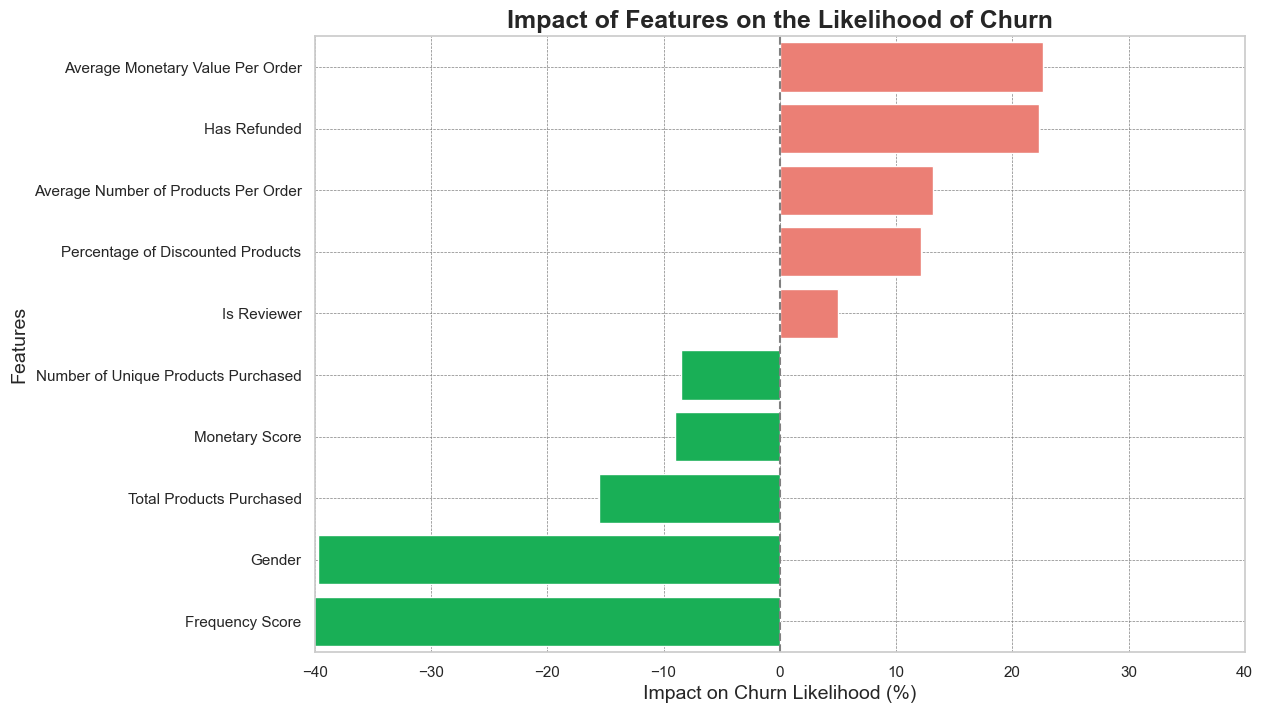

In [47]:
# Rinominare le features secondo i nomi forniti
feature_names = {
    'frequency_score': 'Frequency Score',
    'monetary_score': 'Monetary Score',
    'gender': 'Gender',
    'is_reviewer': 'Is Reviewer',
    'has_refunded': 'Has Refunded',
    'num_unique_products_purchased_score': 'Number of Unique Products Purchased',
    'discounted_purchase_category': 'Percentage of Discounted Products',
    'order_avg_monetary_score': 'Average Monetary Value Per Order',
    'avg_order_num_products_score': 'Average Number of Products Per Order',
    'total_products_purchased_score': 'Total Products Purchased'
}

# Rimuovere la riga 'const'
if 'const' in odds_ratios_df.index:
    odds_ratios_df = odds_ratios_df.drop('const')

# Calcola la variazione percentuale da Odds Ratio
odds_ratios_df['Percentage Change'] = (odds_ratios_df['Odds Ratio'] - 1) * 100

# Resetta l'indice e rinomina le features
odds_ratios_df = odds_ratios_df.reset_index()
odds_ratios_df.rename(columns={'index': 'Features'}, inplace=True)

# Applica i nuovi nomi alle features
odds_ratios_df['Features'] = odds_ratios_df['Features'].replace(feature_names)

# Ordina il DataFrame basato su 'Percentage Change' in ordine decrescente
odds_ratios_df = odds_ratios_df.sort_values('Percentage Change', ascending=False)

# Assegna i colori in base al segno del 'Percentage Change'
colors = ['#FF6F61' if x > 0 else '#00C851' for x in odds_ratios_df['Coefficient']]

# Creazione del barplot con xlim simmetrico
plt.figure(figsize=(12, 8))
barplot = sns.barplot(x='Percentage Change', y='Features', data=odds_ratios_df, palette=colors)
plt.axvline(x=0, color='gray', linestyle='--')  # Aggiunge una linea verticale a zero
plt.xlim(-40, 40)  # Imposta i limiti simmetrici sull'asse X



# Impostazioni estetiche del grafico
plt.title('Impact of Features on the Likelihood of Churn', fontsize=18, weight='bold')
plt.xlabel('Impact on Churn Likelihood (%)', fontsize=14)
plt.ylabel('Features', fontsize=14)
plt.grid(True, which='both', linestyle='--', linewidth='0.5', color='gray')

plt.show()

### Key Insights and Recommendations









#### Feedback and Refund Management
For customers who have requested refunds or provided negative feedback, implement a dedicated support initiative. This could involve setting up a specialized response team that reaches out to these customers proactively to resolve any issues swiftly. The initiative should also include follow-up communications to ensure that the customer's concerns have been satisfactorily addressed, thereby reducing the likelihood of future churn.


#### Targeted Discount Strategies
Develop a program that offers personalized discounts to customers identified with high average spending per order, as this group showed a higher likelihood of churn. The discounts should be tailored based on the customer's purchasing history to enhance perceived value and foster loyalty. For instance, offering a 10% discount on the next purchase after a high-value order could mitigate the churn risk and encourage repeat business.
